In [3]:
import numpy as np
import matplotlib.pyplot as plt
#Correct
#basic model of no accidental death and no mutations
class Bacterium:
    count = 0  # Iterator for unique IDs
    i_b = 1 #rate for reproduction
    i_d = 1/40 #rate for death
    a_d = 0.0000009 #accidental death rate
    
    def __init__(self, x_b, x_d, lansing=False):
        self.id = Bacterium.count  # Unique identity for each bacterium
        Bacterium.count += 1
        self.x_b = x_b  # Give birth until this time
        self.x_d = x_d  # Cannot die before this time
        self.age = 0
        # self.death_event_id = 0
        self.lansing = lansing

    #define representation
    def __repr__(self):
        return f'bacteria number: {self.id}, age: {self.age}'
    
    def reproduce_time(self):
        """Return the time for the next reproduction event."""
        return np.random.exponential(1 / Bacterium.i_b)
    
    def death_time(self):
        """Return the time for the next death event."""
        return np.random.exponential(1 / Bacterium.i_d)
    
    def reproduce(self):
        """
        Generate a child bacterium with parameters drawn from a normal distribution
        around the parent's parameters.
        """
        return Bacterium(self.x_b, self.x_d) 
    
    def reproduce_mut(self, std_dev=1, prob = 1/2): #prob gives the probability that the child mutates
        """
        Generate a child bacterium with parameters drawn from a normal distribution
        around the parent's parameters.
        """
        x_b = self.x_b
        x_d = self.x_d
        rand1 = np.random.rand() #for x_b
        rand2 = np.random.rand() #for x_d
        if rand1 < prob: #with probability p, each of the entries mutate
            x_b = np.random.normal(self.x_b, std_dev)
        if rand2 < prob:
            x_d = np.random.normal(self.x_d, std_dev)
        if x_b>=0 and x_d>=0: 
            return Bacterium(x_b, x_d)
        else: 
            return None
        
    def reproduce_lansing(self, std_dev=1, prob=1/2):
        if self.age < self.x_d:
            return self.reproduce_mut(std_dev, prob)
        else: #if age>=x_d, then the x_d of the offspring becomes 0 before it undergoes the mutations from the normal bd model.
            x_b = self.x_b
            x_d = 0
            rand1 = np.random.rand() #for x_b
            rand2 = np.random.rand() #for x_d
            if rand1 < prob: 
                x_b = np.random.normal(self.x_b, std_dev)
            if rand2 < prob:
                x_d = np.random.normal(0, std_dev)
            if x_b>=0 and x_d>=0: 
                return Bacterium(x_b, x_d, lansing=True)
            else: 
                return None



In [86]:
def count_elems(l):
    count = {}
    for num in l:
        if num in count:
            count[num] += 1
        else:
            count[num] = 1
    return count

In [308]:
#El bueno, creo que no. El hecho de que estamos seleccionando un individuo al azar y luego viendo si cumple con nuestras condiciones (eso es lo que el continue hace) significa 
#que estamos condicionando la probabilidad. 
def simulation_probability(initial_population, max_time, xb_0, xd_0):
    Bacterium.count = 0
    xbs = [xb_0]  # Track x_b values
    xds = [xd_0]  # Track x_d values
    times = [0]   # Track times of events
    time = 0
    population = []
    diff_mean = []
    diff_iter = 0
    for _ in range(initial_population):
        population.append(Bacterium(xb_0, xd_0))

    while time < max_time and population:
        pop = len(population)
        individual_rate = Bacterium.i_b + Bacterium.i_d + pop * Bacterium.a_d
        rate = pop * individual_rate
        event_time = np.random.exponential(1/rate) #beta = 1/lambda recuerdalo joder
        rand = np.random.rand()*rate
        index = int(np.floor(rand/individual_rate))
        bacteria = population[index]
        event_type = None
        if rand <= index * individual_rate + Bacterium.i_b:
            if bacteria.age + event_time > bacteria.x_b:
                continue
            for bacterium in population: #add time to bacteria age
                bacterium.age += event_time
            event_type = 'birth'
            
            new_bacterium = bacteria.reproduce_mut(std_dev=0.05, prob=0.1)
            if new_bacterium:
                population.append(new_bacterium)
                times.append(time)
                xbs.append(new_bacterium.x_b)
                xds.append(new_bacterium.x_d)
                if diff_iter % 1000 == 0:
                    diff_mean.append(np.mean(np.array(xbs)-np.array(xds)))
                    #print(diff_mean)
                #print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {Bacterium.count - 1}, Population: {len(population)}")
                diff_iter += 1
                #print(diff_iter)

                
        elif rand <= index * individual_rate + Bacterium.i_b + Bacterium.i_d:
            if bacteria.age + event_time < bacteria.x_d:
                continue
            for bacterium in population: #add time to bacteria age
                bacterium.age += event_time
            event_type = 'death'
            population.remove(bacteria)
            #print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {bacteria.id}, Population: {len(population)}, Age: {bacteria.age}")
            
        elif rand <= (index + 1) * individual_rate:
            event_type = 'accident'
            for bacterium in population: #add time to bacteria age
                bacterium.age += event_time
            population.remove(bacteria)
            #print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {bacteria.id}, Population: {len(population)}, Age: {bacteria.age}")
        
        time += event_time
        
    return population, xbs, xds, times, diff_mean

In [ ]:
# Bacterium.i_b = 1
# Bacterium.i_d = 1
# Bacterium.a_d = 0.0009
# means_100 = []
# means_200 = []
# means_500 = []
# means_1000 = []

# for i in range(10):
#     pop, xbs, xds, times, mean_diff = simulation_probability(1000, 100, 1.2, 1.6)
#     means_100.append(np.mean(np.array(xbs) - np.array(xds)))

# for i in range(10):
#     pop, xbs, xds, times, mean_diff = simulation_probability(1000, 200, 1.2, 1.6)
#     means_200.append(np.mean(np.array(xbs) - np.array(xds)))

# for i in range(10):
#     pop, xbs, xds, times, mean_diff = simulation_probability(1000, 500, 1.2, 1.6)
#     means_500.append(np.mean(np.array(xbs) - np.array(xds)))

# for i in range(10):
#     pop, xbs, xds, times, mean_diff = simulation_probability(1000, 1000, 1.2, 1.6)
#     means_1000.append(np.mean(np.array(xbs) - np.array(xds)))

In [211]:
np.mean(means_100)

-0.13355285904725525

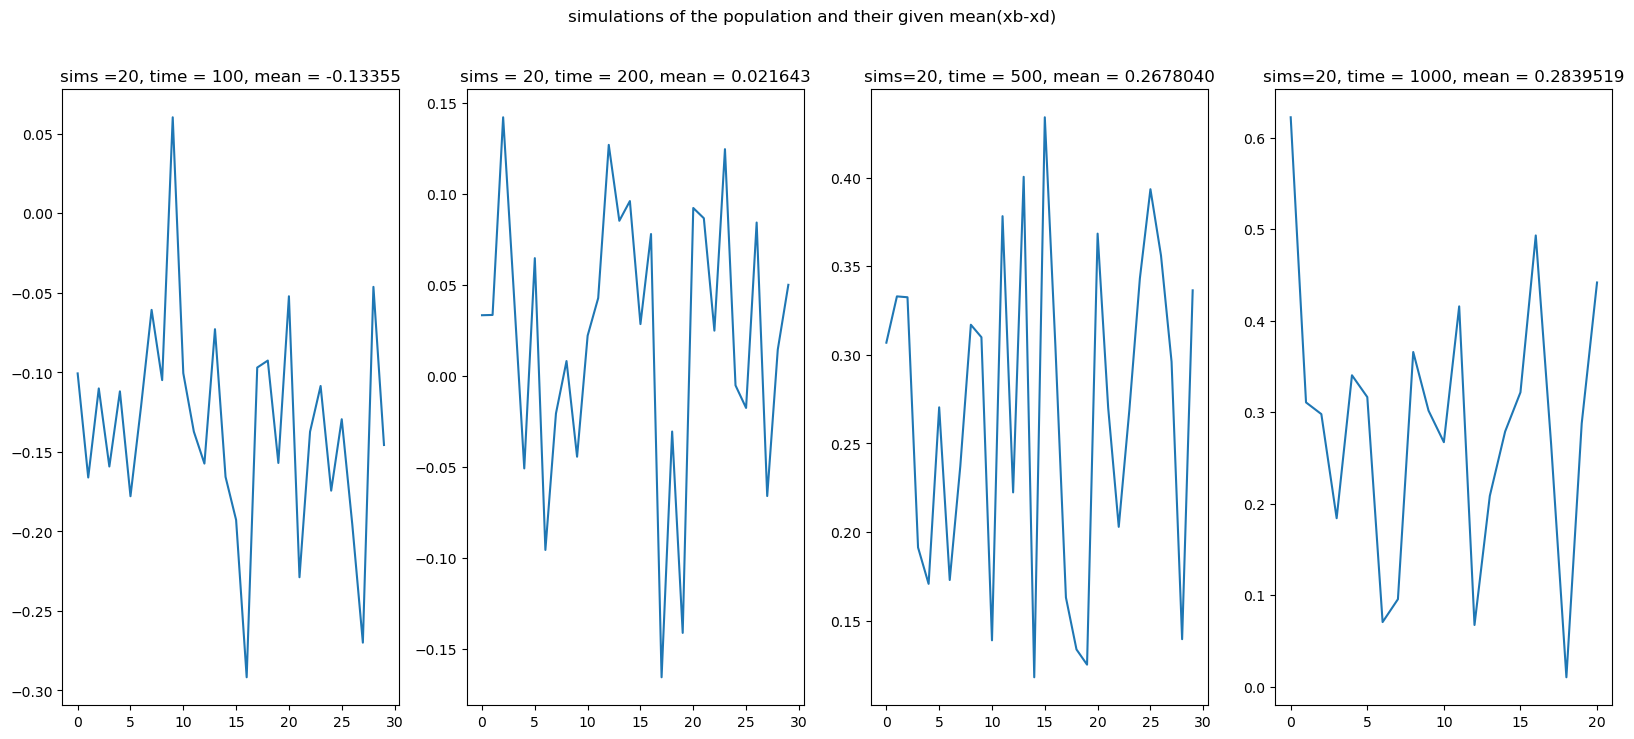

In [216]:
plt.figure(figsize=(20, 8))
plt.suptitle('simulations of the population and their given mean(xb-xd)')
        
plt.subplot(141)
plt.plot(means_100)
plt.title('sims =20, time = 100, mean = -0.13355')

plt.subplot(142)
plt.plot(means_200)
plt.title('sims = 20, time = 200, mean = 0.021643')

plt.subplot(143)
plt.plot(means_500)
plt.title('sims=20, time = 500, mean = 0.2678040')

plt.subplot(144)
plt.plot(means_1000)
plt.title('sims=20, time = 1000, mean = 0.2839519')

plt.savefig('group_project_means1.jpg')

In [196]:
means_2000 = []


for i in range(5):
    pop, xbs, xds, times, mean_diff = simulation_probability(1000, 2000, 1.2, 1.6)
    means_2000.append(np.mean(np.array(xbs) - np.array(xds)))

In [226]:
np.mean(np.mean(means_2000))

1083


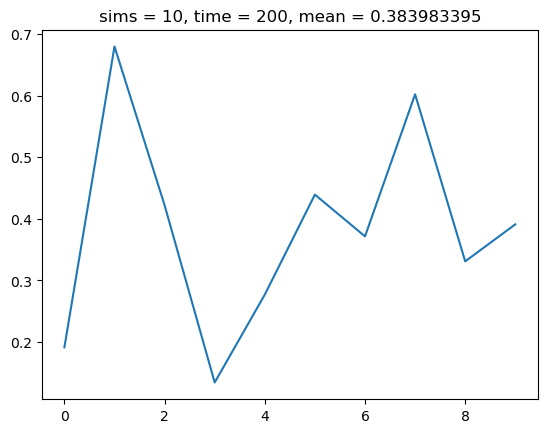

In [220]:
plt.plot(means_2000)
plt.title('sims = 10, time = 200, mean = 0.383983395')

plt.savefig('2000_sims_default_vals.jpg')

In [223]:
means_3000 = []

for i in range(10):
    pop, xbs, xds, times, mean_diff = simulation_probability(1000, 3000, 1.2, 1.6)
    means_3000.append(np.mean(np.array(xbs) - np.array(xds)))

In [225]:
np.mean(means_3000)

0.32005496771494135

In [227]:
Bacterium.a_d = 0.004
means_3000_2 = []
population_3000 = []
xbs_3000 = []
xds_3000 = []
times_3000 = []

for i in range(10):
    pop, xbs, xds, times, _ = simulation_probability(200, 3000, 1.2, 1.6)
    means_3000_2.append(np.mean(np.array(xbs)-np.array(xds)))
    population_3000.append(pop)
    xbs_3000.append(xbs)
    xds_3000.append(xds)
    times_3000.append(times)

In [228]:
print(np.mean(means_3000_2))

0.3550616927484175


In [229]:
means_4000_2 = []
means_5000_2 = []

for i in range(10):
    pop, xbs, xds, times, mean_diff = simulation_probability(200, 4000, 1.2, 1.6)
    means_4000_2.append(np.mean(np.array(xbs) - np.array(xds)))


for i in range(10):
    pop, xbs, xds, times, mean_diff = simulation_probability(200, 5000, 1.2, 1.6)
    means_5000_2.append(np.mean(np.array(xbs) - np.array(xds)))

In [244]:
for i in range(10):
    pop, xbs, xds, times, mean_diff = simulation_probability(200, 5000, 1.2, 1.6)
    means_5000_2.append(np.mean(np.array(xbs) - np.array(xds)))

0.47210070488056033
0.32087575088828596
0.5043600627281519


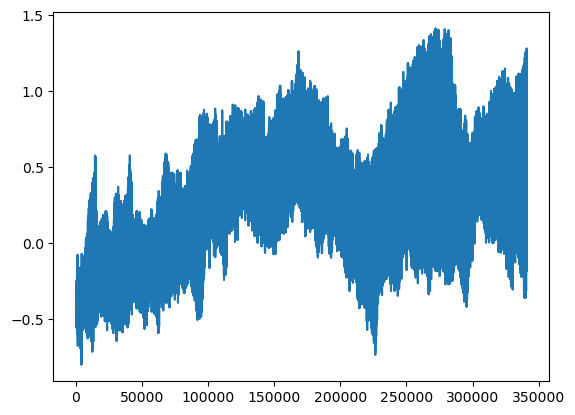

In [260]:
print(np.mean(means_4000_2))
print(np.mean(means_5000_2))
print(np.mean(means_5000_2[26:36]))

diff = np.array(xbs) - np.array(xds)
plt.plot(diff)

In [249]:
#Running simulations with initial population 0, and default values to calculate the mean xb-xd at different values. 20 sims for each
means_100_ = []
means_200_ = []
means_500_ = []
means_1000_ = []


for i in range(20):
    pop, xbs, xds, times, mean_diff = simulation_probability(200, 100, 1.2, 1.6)
    means_100_.append(np.mean(np.array(xbs) - np.array(xds)))

for i in range(20):
    pop, xbs, xds, times, mean_diff = simulation_probability(200, 200, 1.2, 1.6)
    means_200_.append(np.mean(np.array(xbs) - np.array(xds)))

for i in range(20):
    pop, xbs, xds, times, mean_diff = simulation_probability(200, 500, 1.2, 1.6)
    means_500_.append(np.mean(np.array(xbs) - np.array(xds)))

for i in range(20):
    pop, xbs, xds, times, mean_diff = simulation_probability(200, 1000, 1.2, 1.6)
    means_1000_.append(np.mean(np.array(xbs) - np.array(xds)))

In [251]:
#plot mean_diff
print(np.mean(means_100_))
print(np.mean(means_200_))
print(np.mean(means_500_))
print(np.mean(means_1000_))

-0.1685429602963443
-0.05191992007178059
0.185450909850898
0.3218642662841977


In [268]:
pop, xbs, xds, times, mean_diff_1 = simulation_probability(200, 100, 1.2, 1.6)
pop, xbs, xds, times, mean_diff_2 = simulation_probability(200, 200, 1.2, 1.6)
pop, xbs, xds, times, mean_diff_3 = simulation_probability(200, 500, 1.2, 1.6)
pop, xbs, xds, times, mean_diff_4 = simulation_probability(200, 1000, 1.2, 1.6)

In [ ]:
Bacterium.a_d = 0.008
pop, xbs, xds, times, mean_diff_5 = simulation_probability(100, 2000, 1.2, 1.6)
pop, xbs, xds, times, mean_diff_6 = simulation_probability(100, 4000, 1.2, 1.6)
pop, xbs, xds, times, mean_diff_7 = simulation_probability(100, 5000, 1.2, 1.6)

In [301]:
pop, xbs, xds, times, mean_diff_8 = simulation_probability(100, 10000, 1.2, 1.6)
pop, xbs, xds, times, mean_diff_9 = simulation_probability(100, 15000, 1.2, 1.6)
pop, xbs, xds, times, mean_diff_10 = simulation_probability(100, 20000, 1.2, 1.6)

In [323]:
Bacterium.a_d = 0.004
pop, xbs, xds, times, mean_diff = simulation_probability(200, 5000, 1.2, 1.6)

132


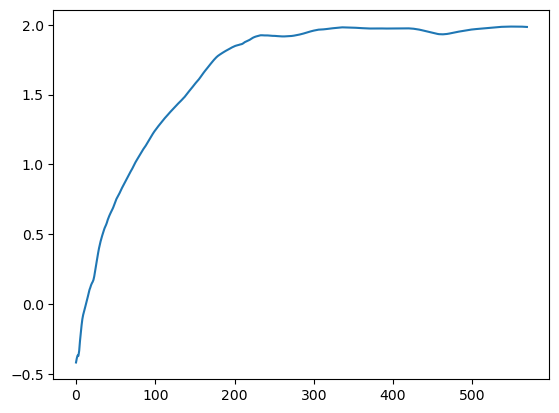

In [321]:
# plt.plot(xbs)
# plt.plot(xds)
plt.plot(mean_diff)
print(len(pop))


In [165]:
import matplotlib.pyplot as plt

diff = np.array(xbs) - np.array(xds)
# plt.plot(times, diff, 'o')
# plt.show()
print(len(diff))
print(len(pop))
print(np.mean(diff[:4936919]))

13014
919
-0.39188041496558346


{5.0: 1, 4.0: 1, 3.0: 10, 2.0: 57, 1.0: 175, 0.0: 851}


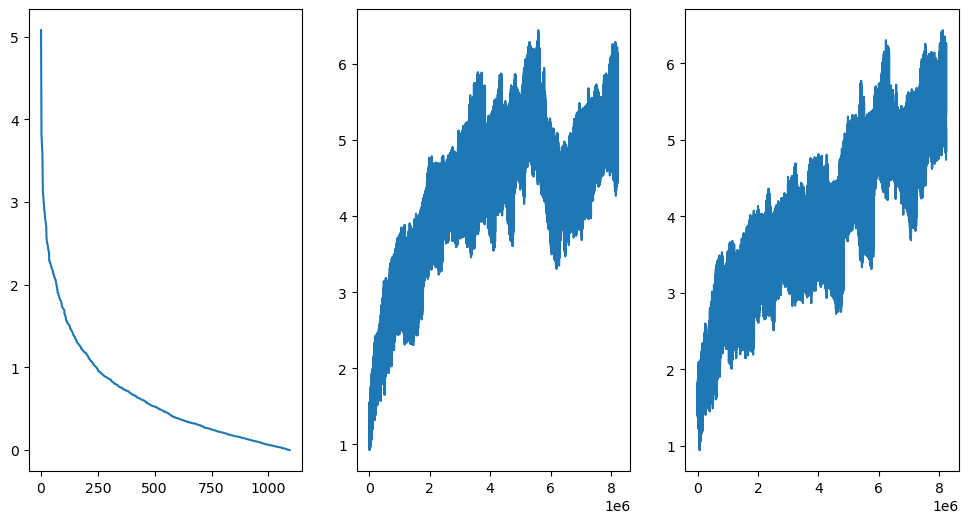

In [92]:
age = [b.age for b in pop]
age_dist = count_elems(np.floor(age))
print(age_dist)

plt.figure(figsize=(12, 6))
        
plt.subplot(131)
plt.plot(age)

plt.subplot(132)
plt.plot(xbs)

plt.subplot(133)
plt.plot(xds)

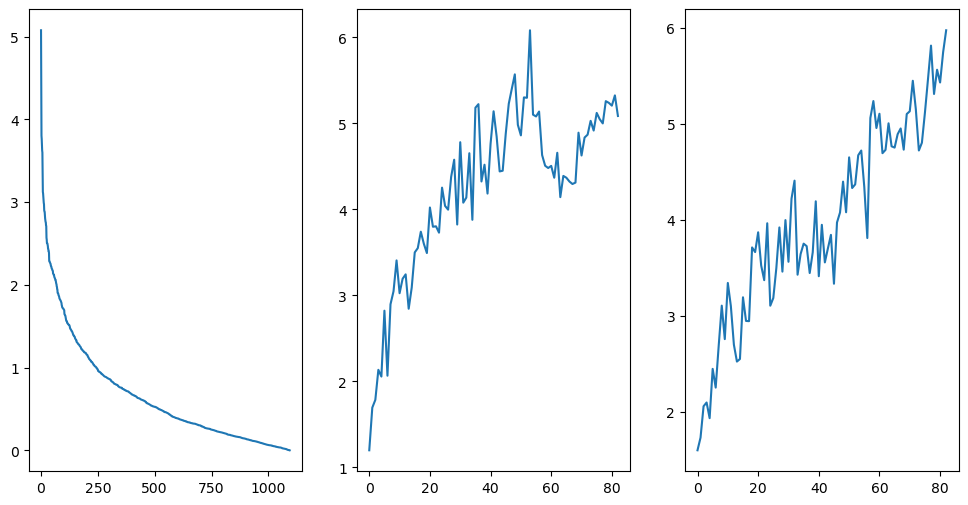

In [115]:
plt.figure(figsize=(12, 6))
        
plt.subplot(131)
plt.plot(age)

plt.subplot(132)
plt.plot(xbs[::100000])

plt.subplot(133)
plt.plot(xds[::100000])

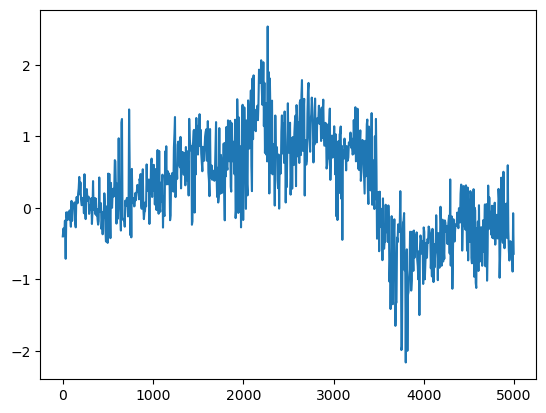

In [114]:
x_reduced = times[::10000]
y_reduced = diff[::10000]

# Plot the reduced lists
plt.plot(x_reduced, y_reduced)

In [84]:
Bacterium.i_b = 1
Bacterium.i_d = 1
Bacterium.a_d = 0.0009
pop, xbs, xds, times = simulation_probability(1000, 5000, 1.2, 1.6)

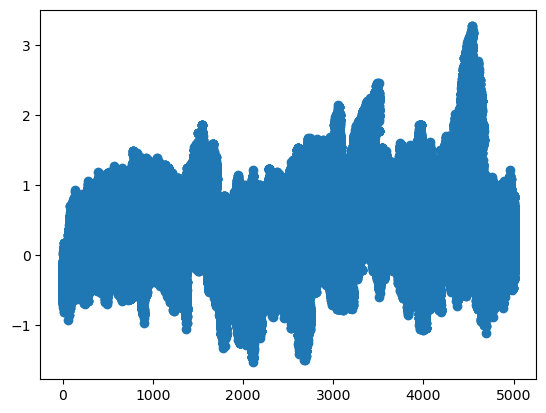

In [85]:
diff = np.array(xbs) - np.array(xds)
plt.plot(times, diff, 'o')
plt.show()

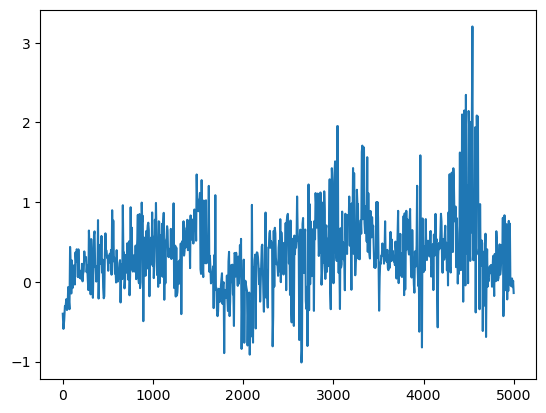

In [86]:
x_reduced = times[::10000]
y_reduced = diff[::10000]

# Plot the reduced lists
plt.plot(x_reduced, y_reduced)

In [149]:
#tenemos que modificar esto segun lo que tenemos abajo, creo que simulation_non_lansing() es la simulacion buena. 
def basic_simulation(initial_population, max_time, xb_0, xd_0):
    Bacterium.count = 0
    times = [0]   # Track times of events
    time = 0
    population = []
    for _ in range(initial_population):
        population.append(Bacterium(xb_0, xd_0))

    while time < max_time and population:
        pop = len(population)
        individual_rate = Bacterium.i_b + Bacterium.i_d #no accidental deaths
        rate = pop * individual_rate
        event_time = np.random.exponential(1/rate) #beta = 1/lambda recuerdalo joder
        rand = np.random.rand()*rate
        index = int(np.floor(rand/individual_rate))
        bacteria = population[index]
        event_type = None
        if rand <= index * individual_rate + Bacterium.i_b:
            if bacteria.age + event_time > bacteria.x_b:
                continue
            for bacterium in population: #add time to bacteria age
                bacterium.age += event_time
            event_type = 'birth'
            
            new_bacterium = bacteria.reproduce()
            population.append(new_bacterium)
            times.append(time)
            #print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {Bacterium.count - 1}, Population: {len(population)}")
                
        elif rand <= index * individual_rate + Bacterium.i_b + Bacterium.i_d:
            if bacteria.age + event_time < bacteria.x_d:
                continue
            for bacterium in population: #add time to bacteria age
                bacterium.age += event_time
            event_type = 'death'
            population.remove(bacteria)
            #print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {bacteria.id}, Population: {len(population)}, Age: {bacteria.age}") 
        time += event_time
        
    return population, times

In [143]:
Bacterium.i_b = 0.15
Bacterium.i_d = 1
end_pop = []

# for i in range(100000):
#     population, _ = basic_simulation(5, 10, np.inf, 0)
#     end_pop.append(len(population))

population, _ = basic_simulation(10, 20, 1.2, 1.6)
age_simple = [b.age for b in population]
print(count_elems(np.floor(age_simple)))

Time: 0.00, Event: birth, Bacterium ID: 10, Population: 11
Time: 0.25, Event: birth, Bacterium ID: 11, Population: 12
Time: 0.32, Event: birth, Bacterium ID: 12, Population: 13
Time: 0.33, Event: birth, Bacterium ID: 13, Population: 14
Time: 0.37, Event: birth, Bacterium ID: 14, Population: 15
Time: 0.38, Event: birth, Bacterium ID: 15, Population: 16
Time: 0.41, Event: birth, Bacterium ID: 16, Population: 17
Time: 0.46, Event: birth, Bacterium ID: 17, Population: 18
Time: 0.61, Event: birth, Bacterium ID: 18, Population: 19
Time: 0.67, Event: birth, Bacterium ID: 19, Population: 20
Time: 0.67, Event: birth, Bacterium ID: 20, Population: 21
Time: 0.85, Event: birth, Bacterium ID: 21, Population: 22
Time: 0.86, Event: birth, Bacterium ID: 22, Population: 23
Time: 0.90, Event: birth, Bacterium ID: 23, Population: 24
Time: 0.92, Event: birth, Bacterium ID: 24, Population: 25
Time: 0.92, Event: birth, Bacterium ID: 25, Population: 26
Time: 0.95, Event: birth, Bacterium ID: 26, Population: 

(array([821., 578., 453., 325., 231., 178.,  41.,   7.,   1.,   1.]),
 array([0.        , 0.29356576, 0.58713152, 0.88069728, 1.17426304,
        1.46782881, 1.76139457, 2.05496033, 2.34852609, 2.64209185,
        2.93565761]),
 <BarContainer object of 10 artists>)

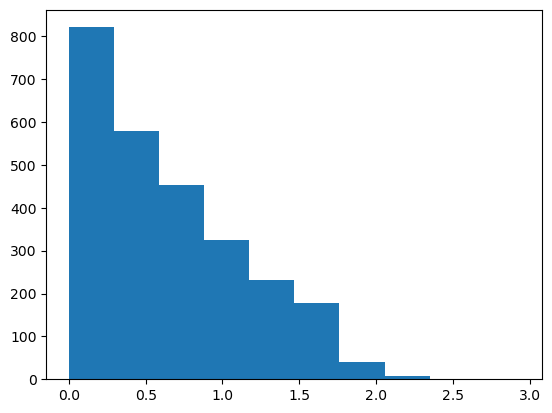

In [136]:
#age_dist_l = list(age_dist.values()) #turns the values of the dictionary into a list
age_dist = count_elems(np.floor(age_simple))
age_simple_sorted = np.sort(age_simple)
plt.hist([b.age for b in population])

# Evolution of age distribution with fixed parameters

In the next cell we will run the basic simulation for the population with initial age 0, initial population 10, ib=0.15, id=1, xb=1.2, xd=1.6, and max_time = 1, 2, 5, 10, 20

In [561]:
def simulation_basic(initial_population, max_time, xb_0, xd_0):
    Bacterium.count = 0
    times = [0]   # Track times of events
    time = 0
    pop = []
    for _ in range(initial_population):
        pop.append(Bacterium(xb_0, xd_0))

    while time < max_time and pop:
        N = len(pop)
        prob_temp = []
        for i in range(N): #creating probabilities of each of the bacterium to have an event
            temp = 0
            if pop[i].age >= pop[i].x_d:
                temp += Bacterium.i_d
            if pop[i].age <= pop[i].x_b:
                temp += Bacterium.i_b
            prob_temp.append(temp)
        # print(np.sum(prob_temp))
        #time = exponential of the sum of all the rates, this comes from the memoryless property of the exponential
        event_time = np.random.exponential(1/np.sum(prob_temp))

        prob_temp = np.array(prob_temp)/np.sum(prob_temp)

        s = np.random.choice(range(N), p=prob_temp)
        # print(s)

        #choosing the event given the individual
        prob_event = [0, 0]
        if pop[s].age >= pop[s].x_d:
            prob_event[1] += Bacterium.i_d
        if pop[s].age <= pop[s].x_b:
            prob_event[0] += Bacterium.i_b
        #print(prob_event)
        prob_event = np.array(prob_event)/np.sum(prob_event)
        event_type = np.random.choice(['birth', 'death'], p=prob_event)
        # print(event_type)

        if event_type == 'birth':
            for bacterium in pop: #add time to bacteria age
                bacterium.age += event_time
            new_bacterium = pop[s].reproduce()
            pop.append(new_bacterium)
            #print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {pop[s].id}, Population: {len(pop)}, Age: {pop[s].age}")
        else:
            for bacterium in pop: #add time to bacteria age
                bacterium.age += event_time
            #print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {pop[s].id}, Population: {len(pop)}, Age: {pop[s].age}")
            pop.remove(pop[s])

        time += event_time

    return pop, times

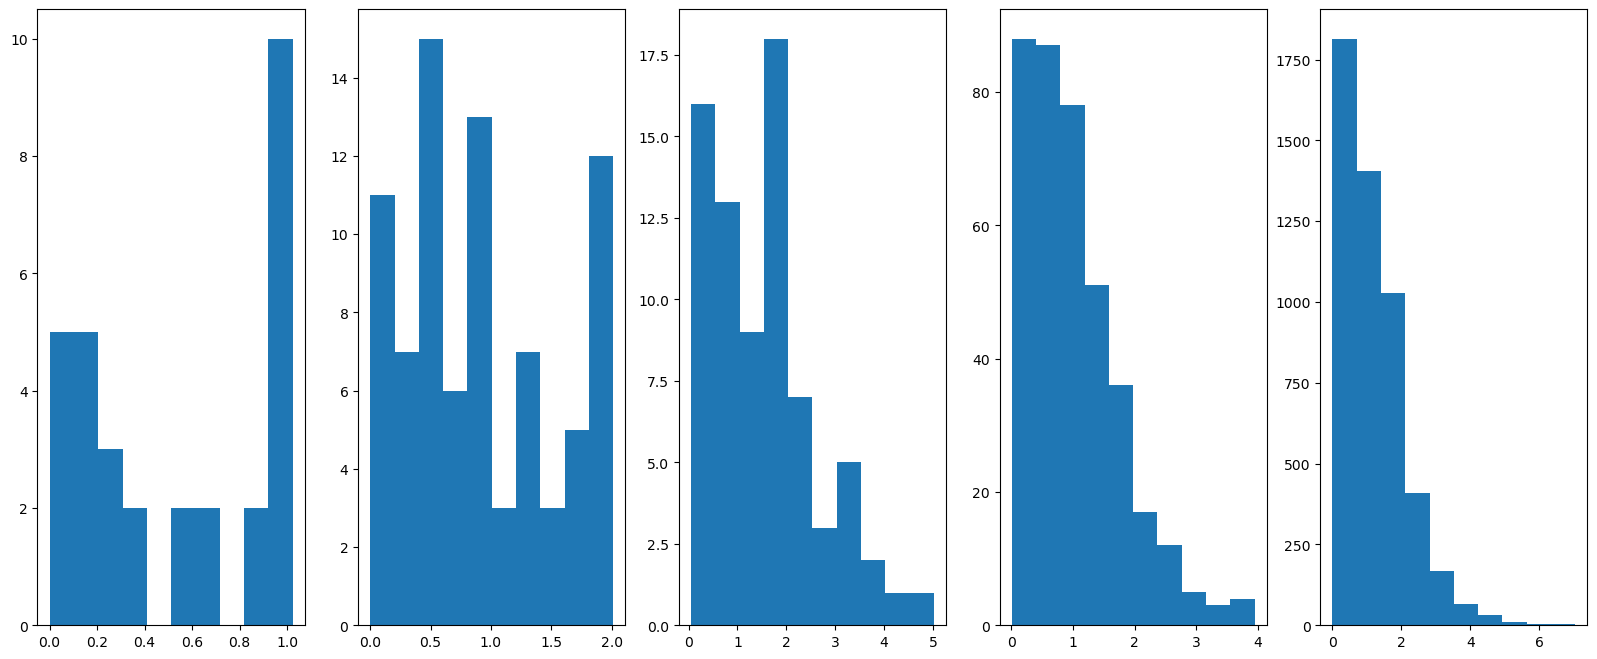

In [742]:
Bacterium.i_b = 1
Bacterium.i_d = 1
max_times = [1, 2, 5, 10, 20]
simulations = []
plt.figure(figsize=(20, 8))
a = 1
for i in max_times:
    temp_pop, _= simulation_basic(10, i, 1.2, 1.6)
    temp_age_dist = [b.age for b in temp_pop]
    plt.subplot(150+a)
    plt.hist(temp_age_dist, label='max_time:{}'.format(i))
    a+=1

plt.savefig('Age distribution evolution for i_d=i_b=1.jpg')

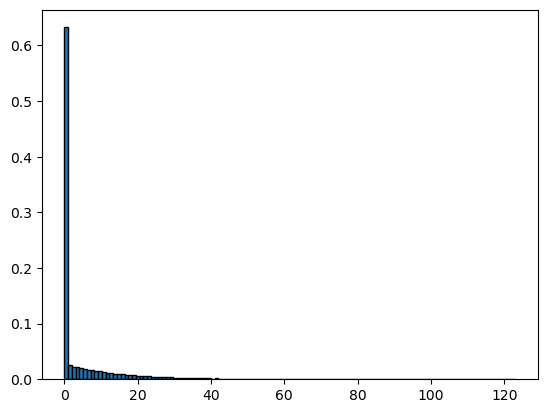

In [82]:
import numpy as np
import matplotlib.pyplot as plt
end_pop = np.array(end_pop)

plt.hist(end_pop, bins=120, edgecolor='black', density=True, stacked=True) # better without histogram, count with table better 
# plt.xlim(0, 10)
# plt.ylim(0, 1)
plt.show()

In [ ]:
import pandas as pd

table = {}
for i in range(len(end_pop)): 
    if end_pop[i] in table:
        table[end_pop[i]] += 1
    else: 
        table[end_pop[i]] = 1
table = list(table.items())
table.sort()

for i in range(len(table)): 
    print('{} | {}'.format(table[i][0], table[i][1]/len(end_pop)))

In [560]:
pop, times = simulation_basic(200, 10, 1.2, 1.6)

Time: 0.00, Event: birth, Bacterium ID: 55, Population: 201, Age: 0.013630850089618701
Time: 0.01, Event: birth, Bacterium ID: 86, Population: 202, Age: 0.0183385109723483
Time: 0.02, Event: birth, Bacterium ID: 188, Population: 203, Age: 0.02275313745326936
Time: 0.02, Event: birth, Bacterium ID: 70, Population: 204, Age: 0.023646966396132844
Time: 0.02, Event: birth, Bacterium ID: 138, Population: 205, Age: 0.030124058236397928
Time: 0.03, Event: birth, Bacterium ID: 69, Population: 206, Age: 0.0352574075074335
Time: 0.04, Event: birth, Bacterium ID: 168, Population: 207, Age: 0.038356075423743086
Time: 0.04, Event: birth, Bacterium ID: 131, Population: 208, Age: 0.046170796417480314
Time: 0.05, Event: birth, Bacterium ID: 62, Population: 209, Age: 0.046196042383998895
Time: 0.05, Event: birth, Bacterium ID: 1, Population: 210, Age: 0.051106054856286796
Time: 0.05, Event: birth, Bacterium ID: 21, Population: 211, Age: 0.07500515863285619
Time: 0.08, Event: birth, Bacterium ID: 9, Pop

In [28]:
diffs = []
for i in range(50):
    pop, xbs, xds, times = simulation_probability(1000, 1000, 1.2, 1.6)
    diff = np.array(xbs) - np.array(xds)
    diffs.append(diff[-1])
    

table = {}
for i in range(len(diffs)): 
    if end_pop[i] in table:
        table[diffs[i]] += 1
    else: 
        table[diffs[i]] = 1
table = list(table.items())
table.sort()

for i in range(len(table)): 
    print('{} | {}'.format(table[i][0], table[i][1]))

# Malthusian Parameter
In the next section we will explore the Malthusian parameter for both Lansing and non-Lansing populations and see how it changes with different values of $i_b, i_d, x_b, x_d$.

In [607]:
# #Functions for calculating the Malthusian parameter
# i_b, i_d, x_b, x_d = 1, 1, 1.2, 1.6
# #For the case where x_d>=x_b: f1 is the function and f1p is the derivative of f1.
# def f1(l):
#     return 1-l/i_b - np.exp(-l*x_b)

# def f1p(l):
#     return -1/i_b + x_b * np.exp(-l * x_b)

# #For the case where x_d < x_b: Same as above, f2 is the function, f2p is the derivative of f2.
# def f2(l):
#     return (1-np.exp(-l*x_d))/l + (np.exp(-l*x_d) - np.exp(-i_d*(x_b-x_d)-l*x_b))/(l+i_d)

# def f2p(l):
#     return ((1-l*x_d)*np.exp(-l*x_d) - 1)/l**2 + ((-x_d*(l+i_d) - 1)*np.exp(-l*x_d) + (x_b + 1)*np.exp(-i_d*(x_b-x_d)-l*x_b))/(l+i_d)**2

# #Malthusian parameter for populations with Lansing effect. 
# def f_lan(l):
#     return (1-np.exp(-l*min(x_b, x_d))) / l - 1/i_b

# def f_lanp(l):
#     return min(x_b, x_d) * np.exp(-l*min(x_b, x_d)) / l - (1-np.exp(-l*min(x_b, x_d))) / l**2

In [ ]:
#Functions for calculating the Malthusian parameter
i_b, i_d, x_b, x_d = 1, 1, 1.3, 1.6
#For the case where x_d>=x_b: f1 is the function and f1p is the derivative of f1.
def f1(l):
    return (1-np.exp(-l*x_b)) / l - 1/i_b

def f1p(l):
    return x_b * np.exp(-l * x_b) / l - (1 - np.exp(-l * x_b)) / l**2

#For the case where x_d < x_b: Same as above, f2 is the function, f2p is the derivative of f2.
def f2(l):
    return 1/l*(1-np.exp(-l*x_d)) + np.exp(i_d*x_d) /(l + i_d) * (np.exp(-(l + i_d)*x_d) - np.exp(-(l + i_d)*x_b)) - 1/i_b

def f2p(l):
    return (l*x_d*np.exp(-l*x_d) - (1-np.exp(-l *x_d)))/l**2 + np.exp(i_d * x_d)/(l + i_d) * (-x_d*np.exp(-(l + i_d)*x_d)+x_b * np.exp(-(l+i_d)*x_b)) - np.exp(i_d * x_d)/(l + i_d)**2 * (np.exp(-(l + i_d)*x_d)- np.exp(-(l+i_d)*x_b))

#Malthusian parameter for populations with Lansing effect. 
def f3(l):
    return (1-np.exp(-l*min(x_b, x_d))) / l - 1/i_b

def f3p(l):
    return min(x_b, x_d) * np.exp(-l*min(x_b, x_d)) / l - (1-np.exp(-l*min(x_b, x_d))) / l**2

In [5]:
def find_malthusian(f, fp, i_0):
    i = 1
    iters = [0, i_0]
    while np.abs(iters[i] - iters[i-1]) > 10**-6:
        iters.append(iters[i] - f(iters[i])/fp(iters[i]))
        i += 1
    return iters[-1]

i_b, i_d, x_b, x_d = 1, 1, 1.2, 1.6
print(find_malthusian(f1, f1p, 0.1))

0.3136983310412174


In [694]:
'''
i_b always be 1, we can argue that this will not affect. We can argue that this does not affect the outcome of the malthusian parameter. Because all the 3 depend on i_b 
the same way, that is the 1/i_b at the end that is subtracting. And neither the last or the first equation depend on i_d. 

Now for the first and the last equations we see that there is no i_d term either, so we actually only have to evaluate the case where i_d is changing for the second equation.That is 
we only need to compare the malthusian parameter for Lansing vs non for x_d < x_b. 

Remember that we are comparing Lansing vs Non-Lansing. 
'''
i_b = 1
i_d = 1
x_b = 1.5 
xds = np.linspace(0.5, 2.5, 100)
l1_non_lansing = []
l1_lansing = []

for i in xds:
    x_d = i
    l1_lansing.append(find_malthusian(f3, f3p, 0.1))
    if x_d >= x_b:
        l1_non_lansing.append(find_malthusian(f1, f1p, 0.1))
    else: 
        l1_non_lansing.append(find_malthusian(f2, f2p, 0.1))

x_d = 1.5
xbs = np.linspace(0.5, 2.5, 100)
l2_non_lansing = []
l2_lansing = []

for i in xbs:
    x_b = i
    l2_lansing.append(find_malthusian(f3, f3p, 0.1))
    if x_d >= x_b:
        l2_non_lansing.append(find_malthusian(f1, f1p, 0.1))
    else: 
        l2_non_lansing.append(find_malthusian(f2, f2p, 0.1))


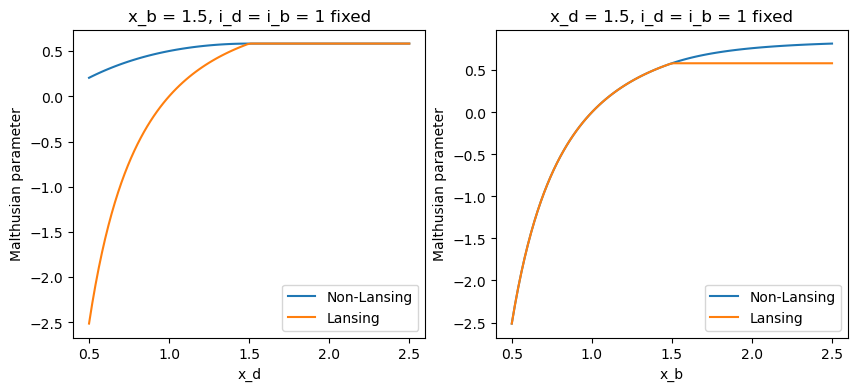

In [739]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(xds, l1_non_lansing, label='Non-Lansing')
plt.plot(xds, l1_lansing, label='Lansing')
plt.title('x_b = 1.5, i_d = i_b = 1 fixed')
plt.ylabel('Malthusian parameter')
plt.xlabel('x_d')
plt.legend()

plt.subplot(122)
plt.plot(xbs, l2_non_lansing, label='Non-Lansing')
plt.plot(xbs, l2_lansing, label='Lansing')
plt.title('x_d = 1.5, i_d = i_b = 1 fixed')
plt.ylabel('Malthusian parameter')
plt.xlabel('x_b')
plt.legend()

plt.savefig('lansing vs non landing for ib = 1.jpg')

In [695]:
i_b = 1.2
i_d = 1.2
x_b = 1.5 
xds = np.linspace(0.5, 2.5, 100)
l3_non_lansing = []
l3_lansing = []

for i in xds:
    x_d = i
    l3_lansing.append(find_malthusian(f3, f3p, 0.1))
    if x_d >= x_b:
        l3_non_lansing.append(find_malthusian(f1, f1p, 0.1))
    else: 
        l3_non_lansing.append(find_malthusian(f2, f2p, 0.1))

x_d = 1.5
xbs = np.linspace(0.5, 2.5, 100)
l4_non_lansing = []
l4_lansing = []

for i in xbs:
    x_b = i
    l4_lansing.append(find_malthusian(f3, f3p, 0.1))
    if x_d >= x_b:
        l4_non_lansing.append(find_malthusian(f1, f1p, 0.1))
    else: 
        l4_non_lansing.append(find_malthusian(f2, f2p, 0.1))


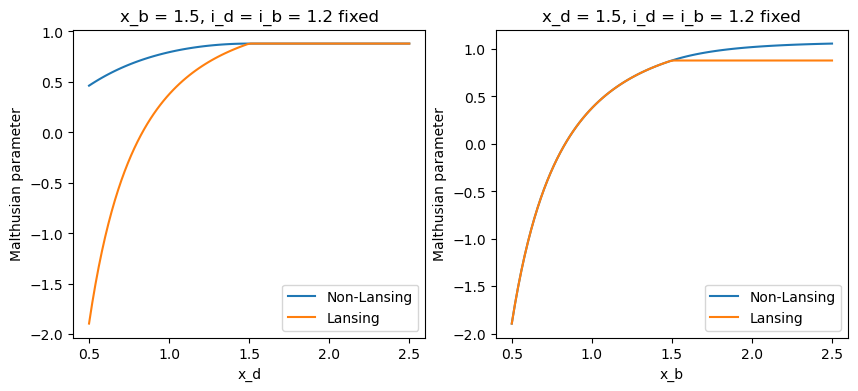

In [738]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(xds, l3_non_lansing, label='Non-Lansing')
plt.plot(xds, l3_lansing, label='Lansing')
plt.title('x_b = 1.5, i_d = i_b = 1.2 fixed')
plt.ylabel('Malthusian parameter')
plt.xlabel('x_d')
plt.legend()

plt.subplot(122)
plt.plot(xbs, l4_non_lansing, label='Non-Lansing')
plt.plot(xbs, l4_lansing, label='Lansing')
plt.title('x_d = 1.5, i_d = i_b = 1.2 fixed')
plt.ylabel('Malthusian parameter')
plt.xlabel('x_b')
plt.legend()


plt.savefig('malthusian parameter, lansing vs non lansing, i_b = 1.2.jpg')

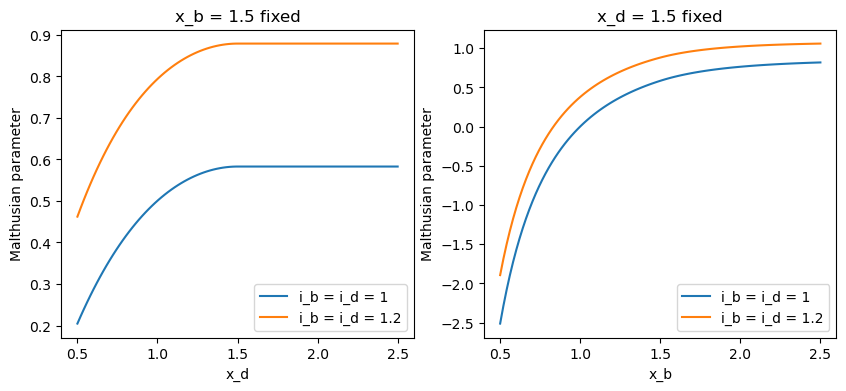

In [736]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(xds, l1_non_lansing, label='i_b = i_d = 1')
plt.plot(xds, l3_non_lansing, label='i_b = i_d = 1.2')
plt.title('x_b = 1.5 fixed')
plt.ylabel('Malthusian parameter')
plt.xlabel('x_d')
plt.legend()

plt.subplot(122)
plt.plot(xbs, l2_non_lansing, label='i_b = i_d = 1')
plt.plot(xbs, l4_non_lansing, label='i_b = i_d = 1.2')
plt.title('x_d = 1.5 fixed')
plt.ylabel('Malthusian parameter')
plt.xlabel('x_b')
plt.legend()


plt.savefig('malthusian parameter, non lansing.jpg')

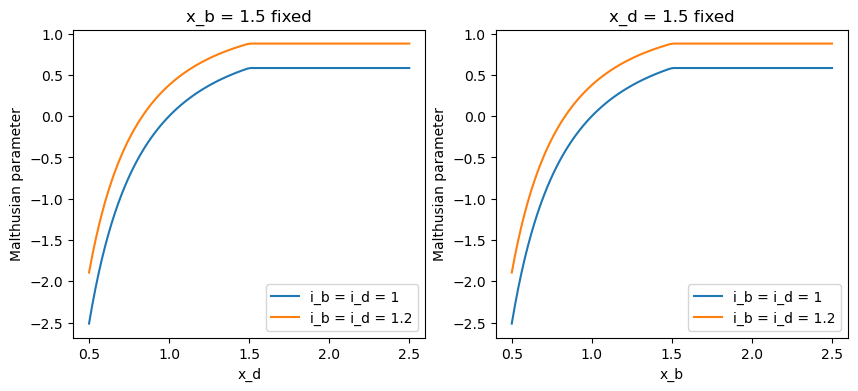

In [737]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(xds, l1_lansing, label='i_b = i_d = 1')
plt.plot(xds, l3_lansing, label='i_b = i_d = 1.2')
plt.title('x_b = 1.5 fixed')
plt.ylabel('Malthusian parameter')
plt.xlabel('x_d')
plt.legend()

plt.subplot(122)
plt.plot(xbs, l2_lansing, label='i_b = i_d = 1')
plt.plot(xbs, l4_lansing, label='i_b = i_d = 1.2')
plt.title('x_d = 1.5 fixed')
plt.ylabel('Malthusian parameter')
plt.xlabel('x_b')
plt.legend()


plt.savefig('malthusian parameter, lansing.jpg')

In [707]:
def malthusian_non_lansing(x_b, x_d):
    if x_d >= x_b:
        return find_malthusian(f1, f1p, 0.1)
    else: 
        return find_malthusian(f2, f2p, 0.1)

def malthusian_lansing(x_b, x_d):
    return 

In [710]:
#Something is not working here
from mpl_toolkits.mplot3d import Axes3D

# Sample data
x_b = np.linspace(0.5, 2.5, 200)
x_d = np.linspace(0.5, 2.5, 200)
X, Y = np.meshgrid(x_b, x_d)
Z = malthusian_lansing(X, Y)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Add color bar
fig.colorbar(surf)

# Labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Surface Plot')

# Show plot
plt.show()


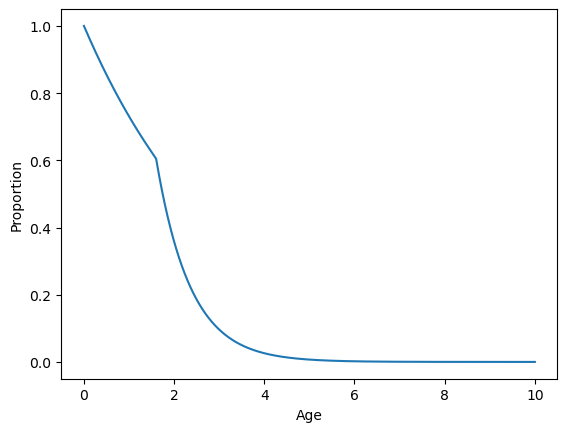

In [34]:
x_d = 1.6
x_b = 1.2
i_d = 1
i_b = 1

def age_dist(a): 
    if a > x_d:
        return np.exp(-i_d*(a-x_d) - find_malthusian(f1, f1p, 0.1)*a)
    else: 
        return np.exp(-find_malthusian(f1, f1p, 0.1)*a)

ages = np.linspace(0, 10, 10000)
distribution = [age_dist(age) for age in ages]

plt.plot(ages, distribution)
plt.xlabel('Age')
plt.ylabel('Proportion')

plt.savefig('N_x(a) for default values.jpg')

#Bibliography

The papers (Roget, Traulsen, Szilagyi, maybe even Charlesworth)

https://www.researchgate.net/figure/Bit-flip-mutation-Each-gene-of-an-individual-has-a-certain-probability-to-perform-the_fig1_341844437 

https://www.gepsoft.com/gepsoft/APS3KB/Chapter06/Section4/SS1.htm 


# Model with competition but no mutations

In [542]:
def simulation_competition(initial_population, max_time, xb_0, xd_0):
    Bacterium.count = 0
    times = [0]   # Track times of events
    time = 0
    pop = []
    for _ in range(initial_population):
        pop.append(Bacterium(xb_0, xd_0))

    while time < max_time and pop:
        N = len(pop)
        prob_temp = []
        for i in range(N): #creating probabilities of each of the bacterium to have an event
            temp = Bacterium.a_d * N
            if pop[i].age >= pop[i].x_d:
                temp += Bacterium.i_d
            if pop[i].age <= pop[i].x_b:
                temp += Bacterium.i_b
            prob_temp.append(temp)
        # print(np.sum(prob_temp))
        #time = exponential of the sum of all the rates, this comes from the memoryless property of the exponential
        event_time = np.random.exponential(1/np.sum(prob_temp))

        prob_temp = np.array(prob_temp)/np.sum(prob_temp)

        s = np.random.choice(range(N), p=prob_temp)
        # print(s)

        #choosing the event given the individual
        prob_event = [0, Bacterium.a_d * N]
        if pop[s].age >= pop[s].x_d:
            prob_event[1] += Bacterium.i_d
        if pop[s].age <= pop[s].x_b:
            prob_event[0] += Bacterium.i_b
        #print(prob_event)
        prob_event = np.array(prob_event)/np.sum(prob_event)
        event_type = np.random.choice(['birth', 'death'], p=prob_event)
        # print(event_type)

        if event_type == 'birth':
            for bacterium in pop: #add time to bacteria age
                bacterium.age += event_time
            new_bacterium = pop[s].reproduce()
            pop.append(new_bacterium)
            times.append(time)
            print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {Bacterium.count - 1}, Population: {len(pop)}")
        
        else:
            for bacterium in pop: #add time to bacteria age
                bacterium.age += event_time
            print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {pop[s].id}, Population: {len(pop)}, Age: {pop[s].age}")
            pop.remove(pop[s])

        time += event_time

    return pop, times

In [552]:
Bacterium.a_d = 0.004
Bacterium.i_b = 1
Bacterium.i_d = 1
pop, times = simulation_competition(200, 100, 1.2, 1.6)

Time: 0.00, Event: death, Bacterium ID: 5, Population: 200, Age: 4.7749458380646435e-05
Time: 0.00, Event: birth, Bacterium ID: 200, Population: 200
Time: 0.00, Event: birth, Bacterium ID: 201, Population: 201
Time: 0.01, Event: death, Bacterium ID: 32, Population: 201, Age: 0.009238740274663291
Time: 0.01, Event: death, Bacterium ID: 104, Population: 200, Age: 0.010341808058682766
Time: 0.01, Event: birth, Bacterium ID: 202, Population: 200
Time: 0.01, Event: death, Bacterium ID: 12, Population: 200, Age: 0.011997884627814948
Time: 0.01, Event: birth, Bacterium ID: 203, Population: 200
Time: 0.02, Event: death, Bacterium ID: 196, Population: 200, Age: 0.024042287597125497
Time: 0.02, Event: birth, Bacterium ID: 204, Population: 200
Time: 0.02, Event: death, Bacterium ID: 194, Population: 200, Age: 0.02872786281414512
Time: 0.03, Event: birth, Bacterium ID: 205, Population: 200
Time: 0.03, Event: birth, Bacterium ID: 206, Population: 201
Time: 0.03, Event: birth, Bacterium ID: 207, Pop

In [593]:
len(pop)

190

# Model with competition and mutations

For the plots, keep up to t=200 for the cases where initial_population=200, and up to t=400 where initial_population=1000

In [482]:
def simulation_non_lansing(initial_population, max_time, xb_0, xd_0):
    Bacterium.count = 0
    xbs = [xb_0]  # Track x_b values
    xds = [xd_0]  # Track x_d values
    times = [0]   # Track times of events
    time = 0
    pop = []
    diff_mean = []
    diff_iter = 0
    for _ in range(initial_population):
        pop.append(Bacterium(xb_0, xd_0))

    while time < max_time and pop:
        N = len(pop)
        prob_temp = []
        for i in range(N): #creating probabilities of each of the bacterium to have an event
            temp = Bacterium.a_d * N
            if pop[i].age >= pop[i].x_d:
                temp += Bacterium.i_d
            if pop[i].age <= pop[i].x_b:
                temp += Bacterium.i_b
            prob_temp.append(temp)
        # print(np.sum(prob_temp))
        #time = exponential of the sum of all the rates, this comes from the memoryless property of the exponential
        event_time = np.random.exponential(1/np.sum(prob_temp))

        prob_temp = np.array(prob_temp)/np.sum(prob_temp)

        s = np.random.choice(range(N), p=prob_temp)
        # print(s)

        #choosing the event given the individual
        prob_event = [0, Bacterium.a_d * N]
        if pop[s].age >= pop[s].x_d:
            prob_event[1] += Bacterium.i_d
        if pop[s].age <= pop[s].x_b:
            prob_event[0] += Bacterium.i_b
        #print(prob_event)
        prob_event = np.array(prob_event)/np.sum(prob_event)
        event_type = np.random.choice(['birth', 'death'], p=prob_event)
        # print(event_type)

        if event_type == 'birth':
            for bacterium in pop: #add time to bacteria age
                bacterium.age += event_time
            new_bacterium = pop[s].reproduce_mut(std_dev=0.05, prob=0.1)
            if new_bacterium:
                pop.append(new_bacterium)
                times.append(time)
                xbs.append(new_bacterium.x_b)
                xds.append(new_bacterium.x_d)
                if diff_iter % 1000 == 0:
                    diff_mean.append(np.mean(np.array(xbs)-np.array(xds)))
                    #print(diff_mean)
                # print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {Bacterium.count - 1}, Population: {len(pop)}")
                diff_iter += 1
                #print(diff_iter)
        
        else:
            for bacterium in pop: #add time to bacteria age
                bacterium.age += event_time
            # print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {pop[s].id}, Population: {len(pop)}, Age: {pop[s].age}")
            pop.remove(pop[s])

        time += event_time

    return pop, xbs, xds, times, diff_mean

In [757]:
Bacterium.a_d = 0.0009
Bacterium.i_b = 1
Bacterium.i_d = 1
pop, xbs, xds, times, mean_diff = simulation_non_lansing(1000, 200, 1.2, 1.6)

In [590]:
Bacterium.a_d = 0.004
Bacterium.i_b = 1
Bacterium.i_d = 1
pop18, xbs18, xds18, times18, mean_diff18 = simulation_non_lansing(200, 400, 1.2, 1.6)

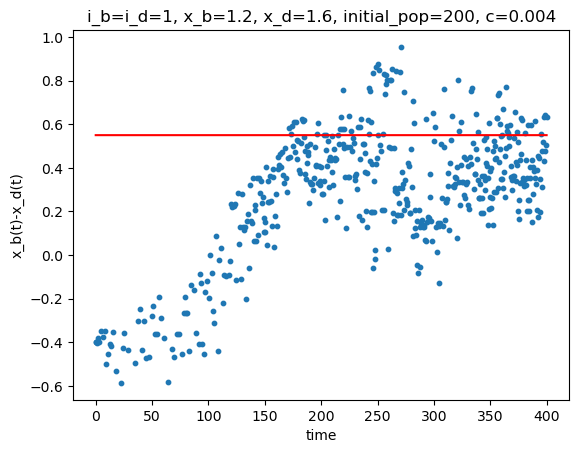

In [591]:
plt.scatter(y =(np.array(xbs18)-np.array(xds18))[::100], x = times18[::100], s=10)
plt.plot(times18,[0.55 for i in range(len(times18))], color='red')
plt.title('i_b=i_d=1, x_b=1.2, x_d=1.6, initial_pop=200, c=0.004')
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')
plt.savefig('200_individuals_sim_t200_higher_competition.jpg')

In [409]:
pop1, xbs1, xds1, times1, mean_diff1 = simulation_non_lansing(1000, 400, 1.2, 1.6)

In [428]:
pop2, xbs2, xds2, times2, mean_diff2 = simulation_non_lansing(1000, 1000, 1.2, 1.6)

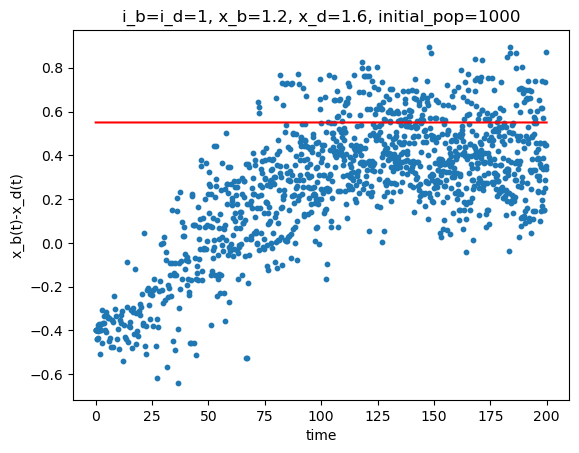

In [763]:
# plt.plot(xbs)
# plt.plot(xds)
# plt.plot(mean_diff)
plt.scatter(y =(np.array(xbs)-np.array(xds))[::100], x = times[::100], s=10)
plt.plot(times1,[0.55 for i in range(len(times1))], color='red')
plt.title('i_b=i_d=1, x_b=1.2, x_d=1.6, initial_pop=1000')
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')
plt.savefig('default_sim_t200.jpg')

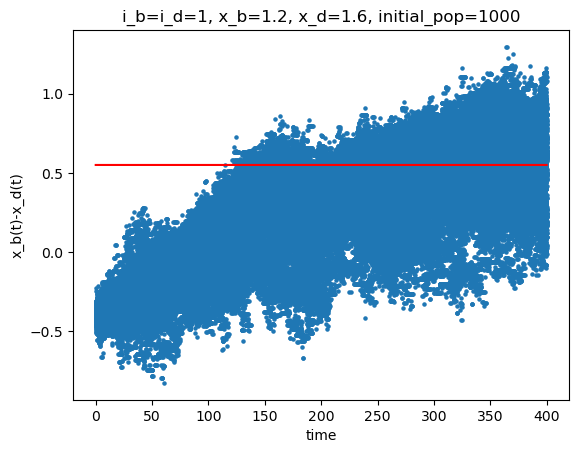

In [441]:
plt.scatter(y =(np.array(xbs1)-np.array(xds1)), x = times1, s=5)
plt.plot(times1,[0.55 for i in range(len(times1))], color='red')
plt.title('i_b=i_d=1, x_b=1.2, x_d=1.6, initial_pop=1000')
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')
plt.savefig('default_sim_t400.jpg')

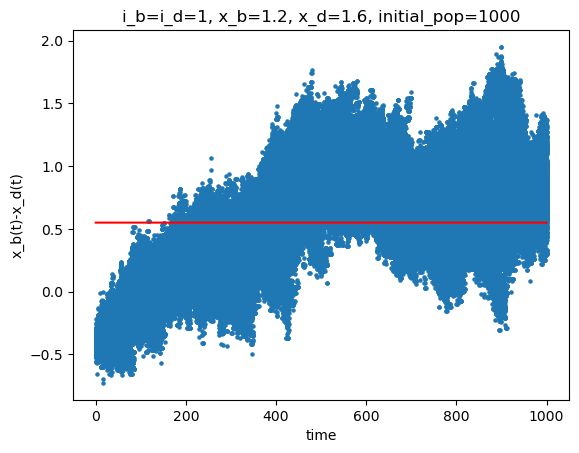

In [442]:
plt.scatter(y =(np.array(xbs2)-np.array(xds2)), x = times2, s=5)
plt.plot(times2,[0.55 for i in range(len(times2))], color='red')
plt.title('i_b=i_d=1, x_b=1.2, x_d=1.6, initial_pop=1000')
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')
plt.savefig('default_sim_t1000.jpg')

In [429]:
pop3, xbs3, xds3, times3, mean_diff3 = simulation_non_lansing(1000, 200, 1.2, 1.2)
pop4, xbs4, xds4, times4, mean_diff4 = simulation_non_lansing(1000, 400, 1.2, 1.2)
pop5, xbs5, xds5, times5, mean_diff5 = simulation_non_lansing(1000, 1000, 1.2, 1.2)

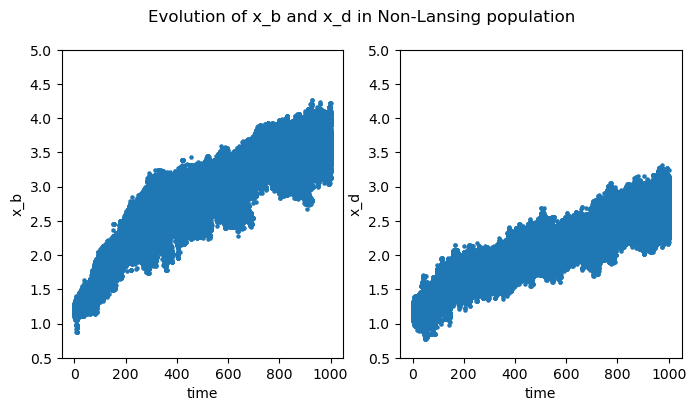

In [650]:
#plots of the evolution of xbs and xds
plt.figure(figsize=(8, 4))
plt.suptitle('Evolution of x_b and x_d in Non-Lansing population')

plt.subplot(121)
plt.scatter(times5, xbs5, s=5)
plt.ylabel('x_b')
plt.xlabel('time')
plt.ylim(0.5, 5)

plt.subplot(122)
plt.scatter(times5, xds5, s=5)
plt.ylabel('x_d')
plt.xlabel('time')
plt.ylim(0.5, 5)

plt.savefig('Evolution of xbs and xds in a Non-Lansing populaiton.jpg')

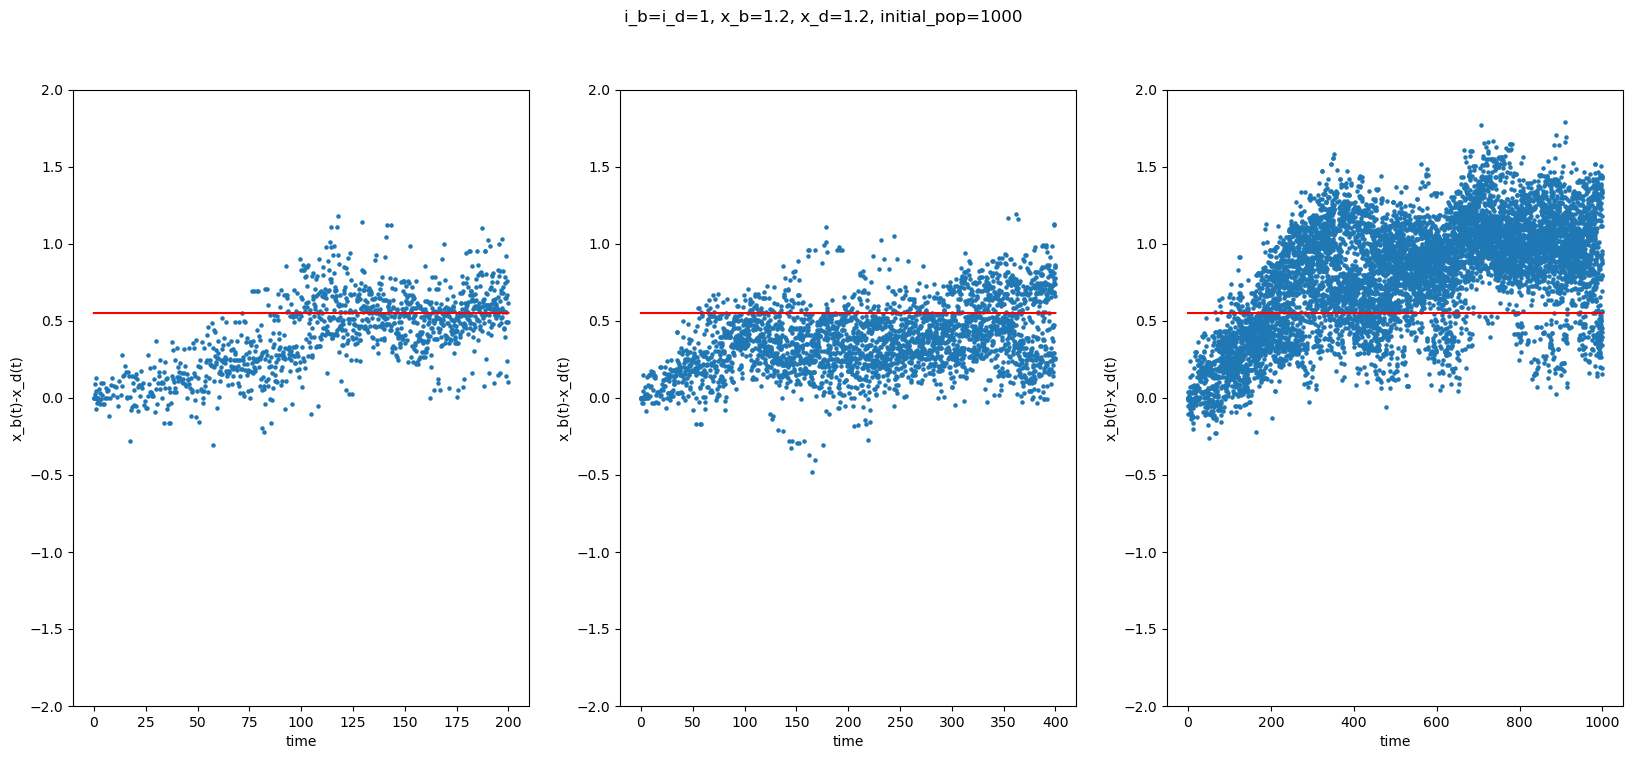

In [451]:
plt.figure(figsize=(20, 8))
plt.suptitle('i_b=i_d=1, x_b=1.2, x_d=1.2, initial_pop=1000')
        
plt.subplot(131)
plt.scatter(y =(np.array(xbs3)-np.array(xds3))[::100], x = times3[::100], s=5)
plt.plot(times,[0.55 for i in range(len(times))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.subplot(132)
plt.scatter(y =(np.array(xbs4)-np.array(xds4))[::100], x = times4[::100], s=5)
plt.plot(times1,[0.55 for i in range(len(times1))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.subplot(133)
plt.scatter(y =(np.array(xbs5)-np.array(xds5))[::100], x = times5[::100], s=5)
plt.plot(times2,[0.55 for i in range(len(times2))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.savefig('xb_x_d_equal_with_line_default.jpg')

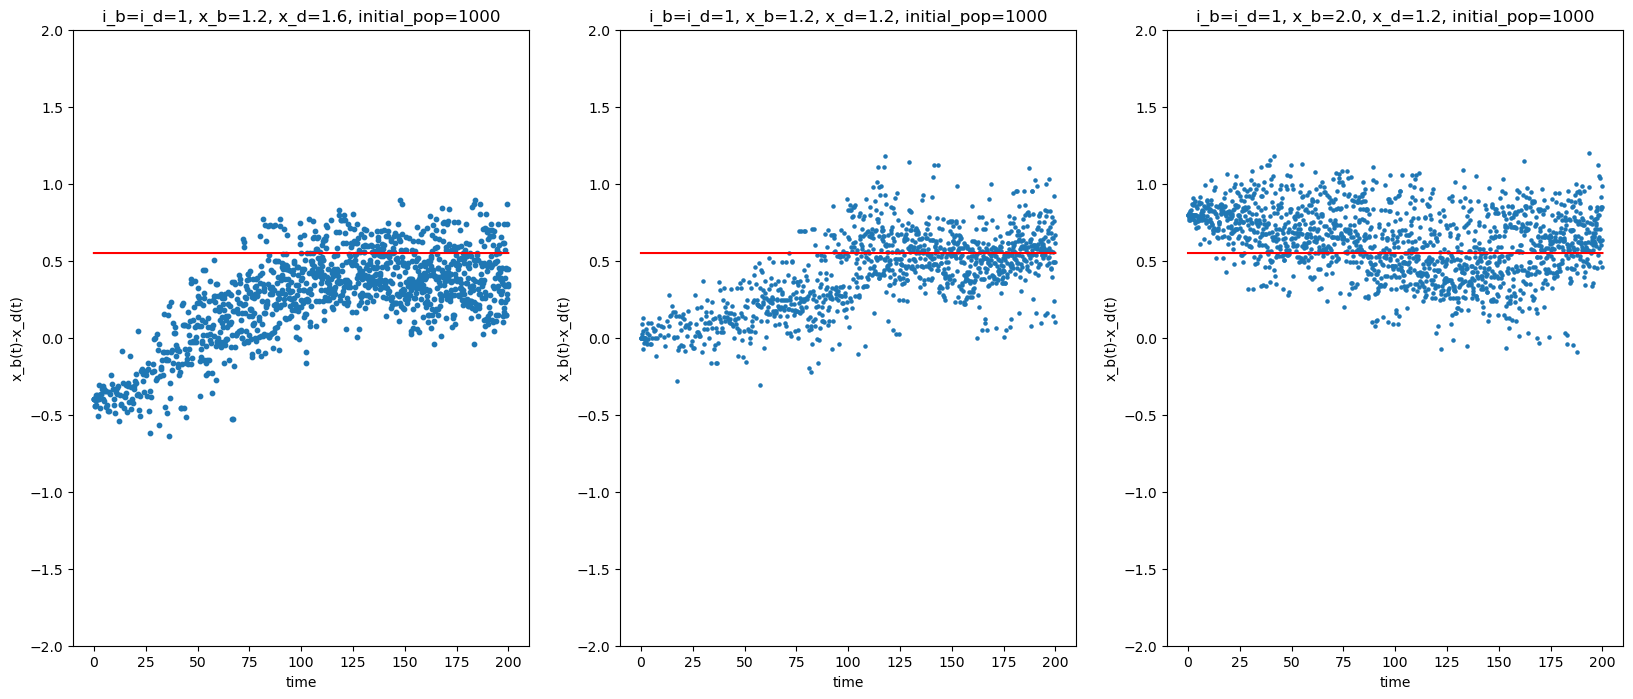

In [766]:
plt.figure(figsize=(20, 8))

plt.subplot(131)
plt.scatter(y =(np.array(xbs)-np.array(xds))[::100], x = times[::100], s=10)
plt.plot(times1,[0.55 for i in range(len(times1))], color='red')
plt.title('i_b=i_d=1, x_b=1.2, x_d=1.6, initial_pop=1000')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.subplot(132)
plt.scatter(y =(np.array(xbs3)-np.array(xds3))[::100], x = times3[::100], s=5)
plt.plot(times,[0.55 for i in range(len(times))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')
plt.title('i_b=i_d=1, x_b=1.2, x_d=1.2, initial_pop=1000')


plt.subplot(133)
plt.scatter(y =(np.array(xbs6)-np.array(xds6))[::100], x = times6[::100], s=5)
plt.plot(times,[0.55 for i in range(len(times))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')
plt.title('i_b=i_d=1, x_b=2.0, x_d=1.2, initial_pop=1000')

plt.savefig('non-lansing convergence.jpg')

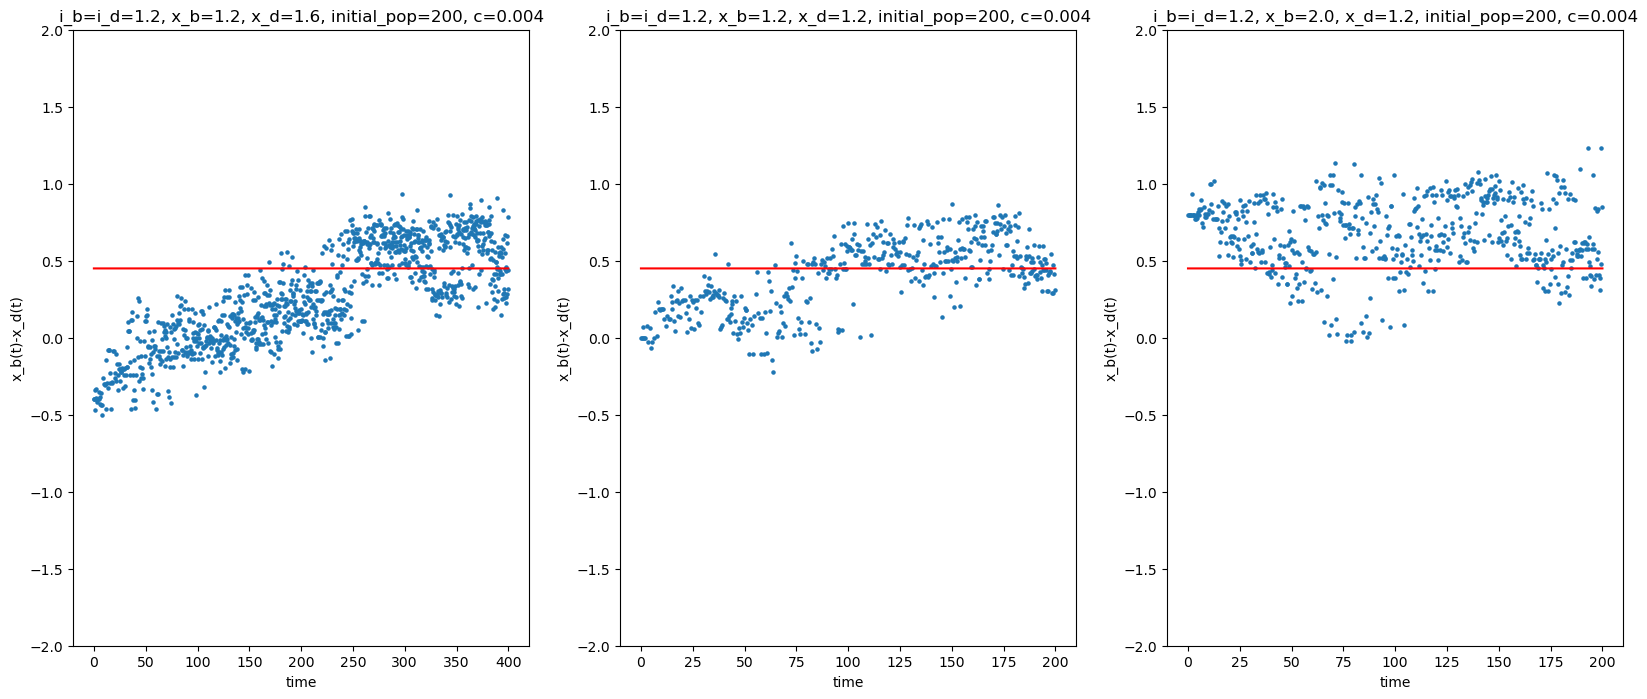

In [767]:
plt.figure(figsize=(20, 8))


plt.subplot(131)
plt.scatter(y =(np.array(xbs10)-np.array(xds10))[::100], x = times10[::100], s=5)
plt.plot(times10,[0.45 for i in range(len(times10))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')
plt.title('i_b=i_d=1.2, x_b=1.2, x_d=1.6, initial_pop=200, c=0.004')

plt.subplot(132)
plt.scatter(y =(np.array(xbs12)-np.array(xds12))[::100], x = times12[::100], s=5)
plt.plot(times,[0.45 for i in range(len(times))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')
plt.title('i_b=i_d=1.2, x_b=1.2, x_d=1.2, initial_pop=200, c=0.004')


plt.subplot(133)
plt.scatter(y =(np.array(xbs15)-np.array(xds15))[::100], x = times15[::100], s=5)
plt.plot(times,[0.45 for i in range(len(times))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')
plt.title('i_b=i_d=1.2, x_b=2.0, x_d=1.2, initial_pop=200, c=0.004')

plt.savefig('non-lansing convergence 2.jpg')


In [467]:
Bacterium.a_d = 0.0009
Bacterium.i_b = 1
Bacterium.i_d = 1
pop6, xbs6, xds6, times6, mean_diff6 = simulation_non_lansing(1000, 200, 2.0, 1.2)
pop7, xbs7, xds7, times7, mean_diff7 = simulation_non_lansing(1000, 400, 2.0, 1.2)
pop8, xbs8, xds8, times8, mean_diff8 = simulation_non_lansing(1000, 1000, 2.0, 1.2)

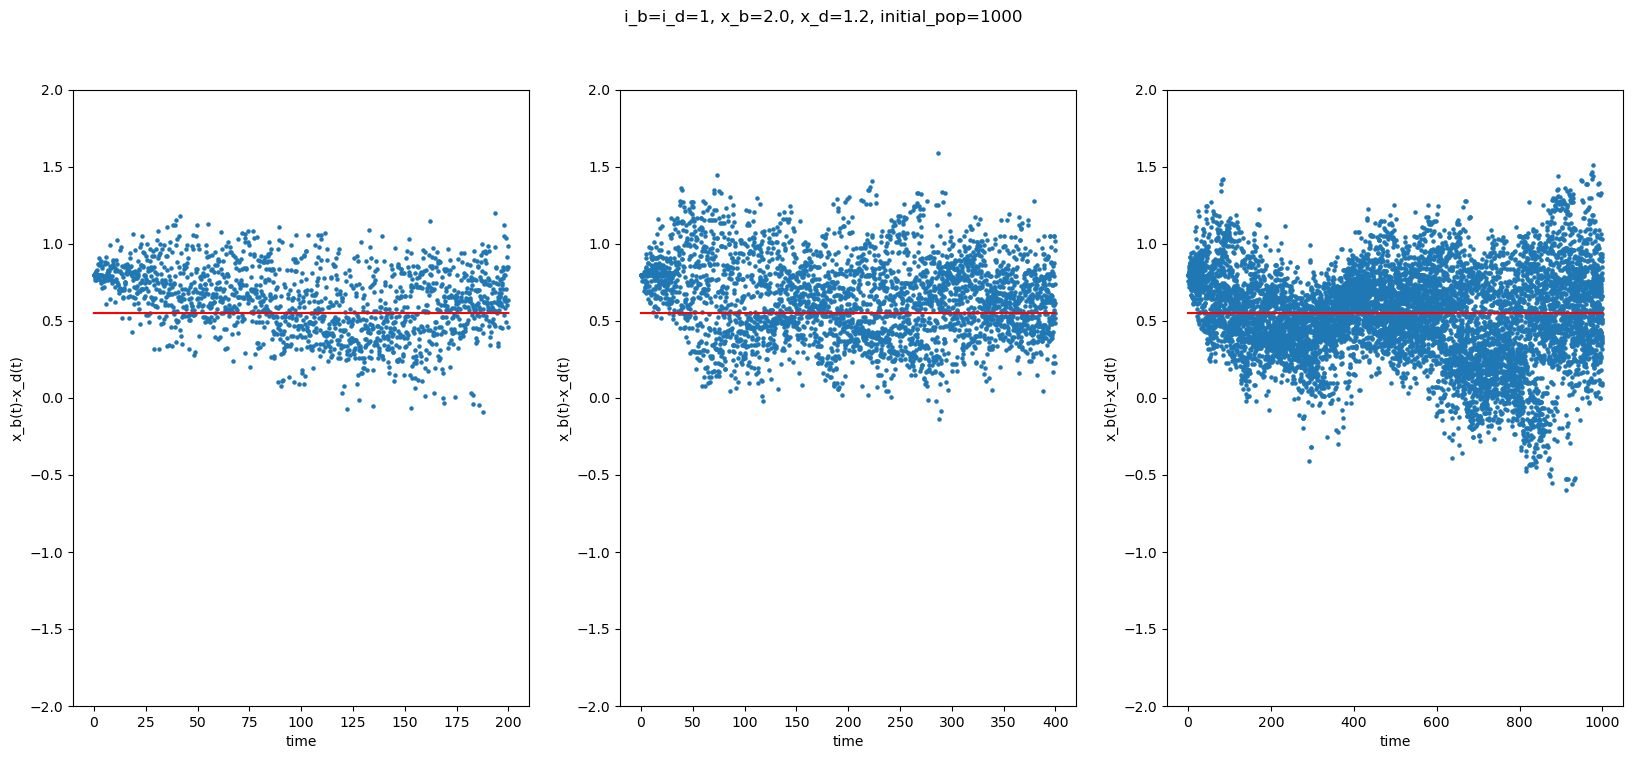

In [473]:
plt.figure(figsize=(20, 8))
plt.suptitle('i_b=i_d=1, x_b=2.0, x_d=1.2, initial_pop=1000')
plt.ylabel('time')
plt.xlabel('x_b(t) - x_d(t)')
        
plt.subplot(131)
plt.scatter(y =(np.array(xbs6)-np.array(xds6))[::100], x = times6[::100], s=5)
plt.plot(times,[0.55 for i in range(len(times))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.subplot(132)
plt.scatter(y =(np.array(xbs7)-np.array(xds7))[::100], x = times7[::100], s=5)
plt.plot(times1,[0.55 for i in range(len(times1))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.subplot(133)
plt.scatter(y =(np.array(xbs8)-np.array(xds8))[::100], x = times8[::100], s=5)
plt.plot(times2,[0.55 for i in range(len(times2))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.savefig('xb_more_with_line_default.jpg')

In [431]:
Bacterium.a_d = 0.004
Bacterium.i_b = 1.2
Bacterium.i_d = 1.2
pop9, xbs9, xds9, times9, mean_diff9 = simulation_non_lansing(200, 200, 1.2, 1.6)
pop10, xbs10, xds10, times10, mean_diff10 = simulation_non_lansing(200, 400, 1.2, 1.6)
pop11, xbs11, xds11, times11, mean_diff11 = simulation_non_lansing(200, 1000, 1.2, 1.6)

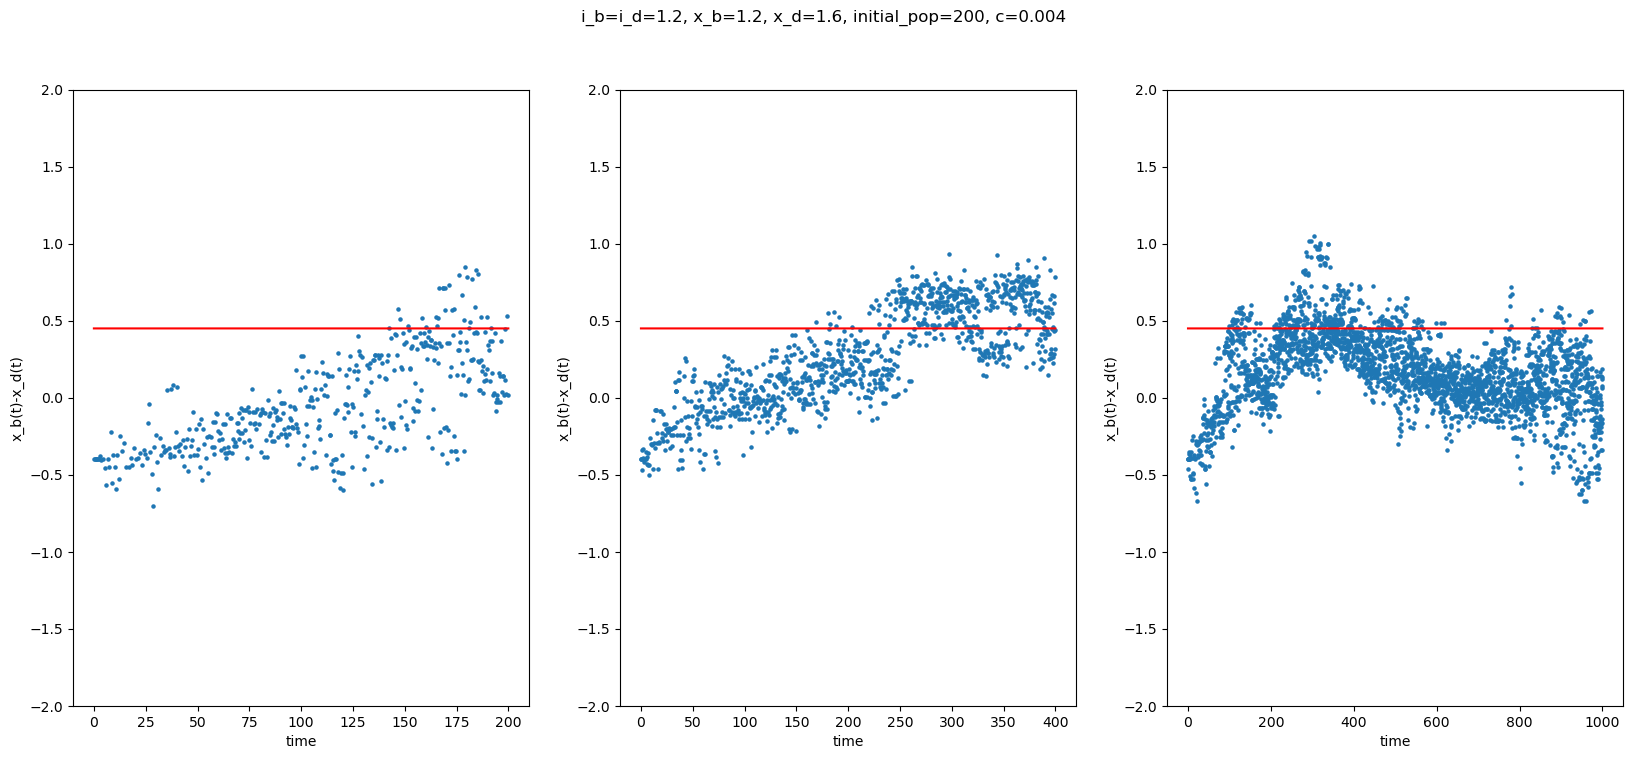

In [457]:
plt.figure(figsize=(20, 8))
plt.suptitle('i_b=i_d=1.2, x_b=1.2, x_d=1.6, initial_pop=200, c=0.004')
plt.ylabel('time')
plt.xlabel('x_b(t) - x_d(t)')
        
plt.subplot(131)
plt.scatter(y =(np.array(xbs9)-np.array(xds9))[::100], x = times9[::100], s=5)
plt.plot(times,[0.45 for i in range(len(times))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.subplot(132)
plt.scatter(y =(np.array(xbs10)-np.array(xds10))[::100], x = times10[::100], s=5)
plt.plot(times1,[0.45 for i in range(len(times1))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.subplot(133)
plt.scatter(y =(np.array(xbs11)-np.array(xds11))[::100], x = times11[::100], s=5)
plt.plot(times2,[0.45 for i in range(len(times2))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')


plt.savefig('xb_less_with_line_high_i_b.jpg')

In [468]:
Bacterium.a_d = 0.004
Bacterium.i_b = 1.2
Bacterium.i_d = 1.2
pop12, xbs12, xds12, times12, mean_diff12 = simulation_non_lansing(200, 200, 1.2, 1.2)
pop13, xbs13, xds13, times13, mean_diff13 = simulation_non_lansing(200, 400, 1.2, 1.2)
pop14, xbs14, xds14, times14, mean_diff14 = simulation_non_lansing(200, 1000, 1.2, 1.2)

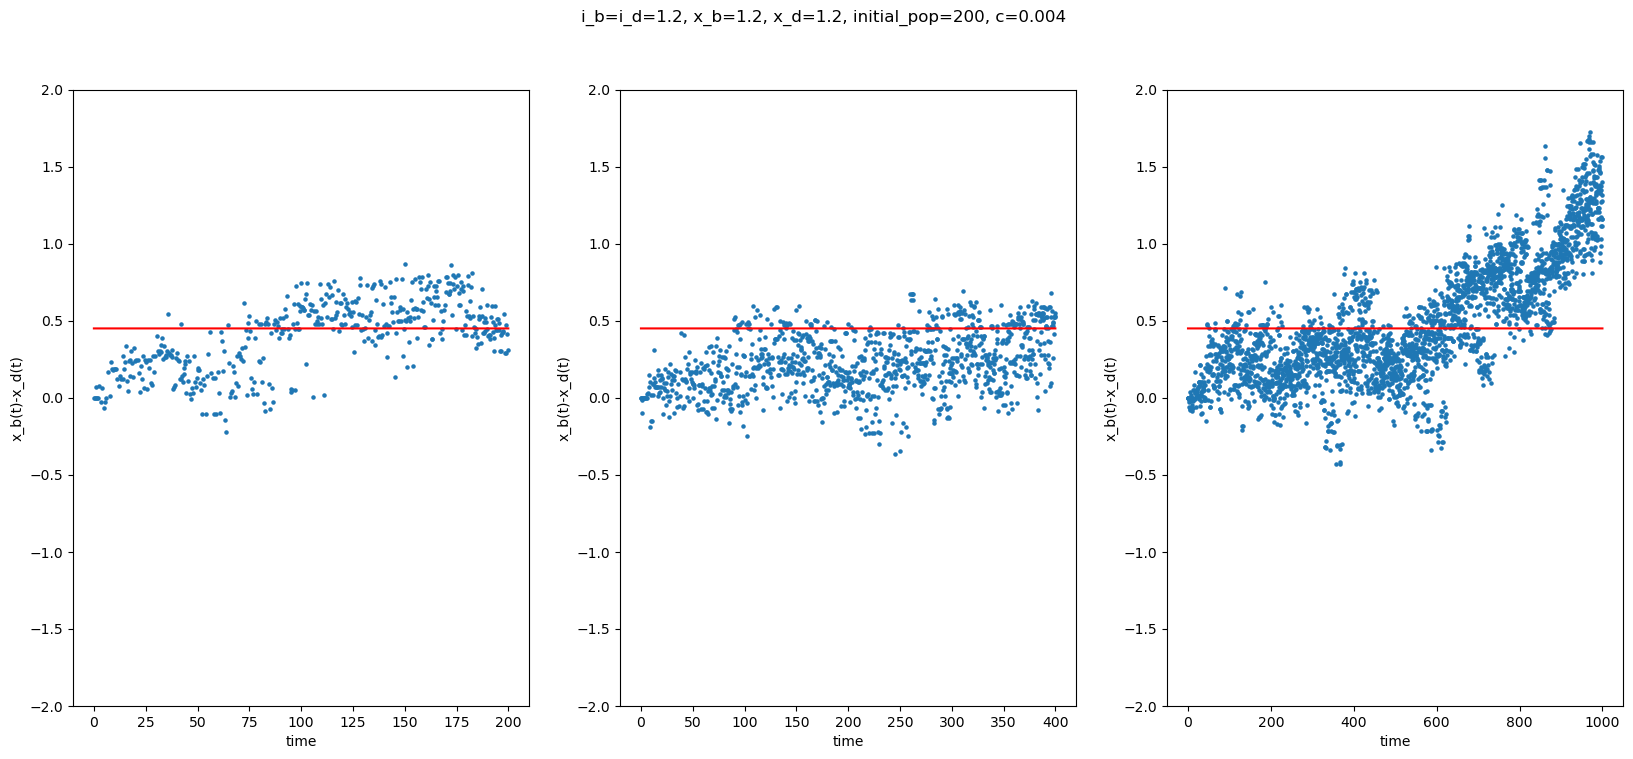

In [471]:
plt.figure(figsize=(20, 8))
plt.suptitle('i_b=i_d=1.2, x_b=1.2, x_d=1.2, initial_pop=200, c=0.004')
plt.ylabel('time')
plt.xlabel('x_b(t) - x_d(t)')
        
plt.subplot(131)
plt.scatter(y =(np.array(xbs12)-np.array(xds12))[::100], x = times12[::100], s=5)
plt.plot(times,[0.45 for i in range(len(times))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.subplot(132)
plt.scatter(y =(np.array(xbs13)-np.array(xds13))[::100], x = times13[::100], s=5)
plt.plot(times1,[0.45 for i in range(len(times1))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.subplot(133)
plt.scatter(y =(np.array(xbs14)-np.array(xds14))[::100], x = times14[::100], s=5)
plt.plot(times2,[0.45 for i in range(len(times2))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.savefig('xb_equal_with_line_high_i_b.jpg')

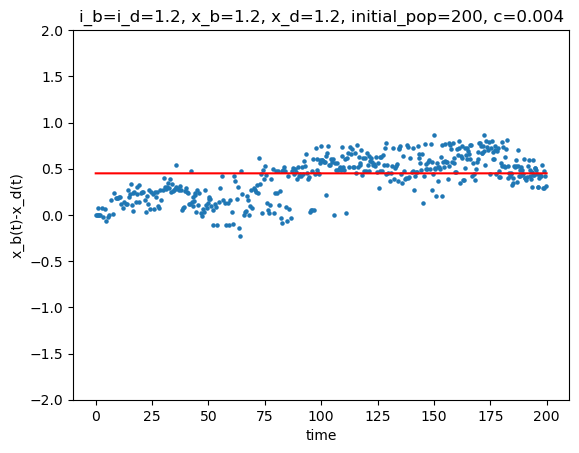

In [740]:
plt.scatter(y =(np.array(xbs12)-np.array(xds12))[::100], x = times12[::100], s=5)
plt.plot(times,[0.45 for i in range(len(times))], color='red')
plt.title('i_b=i_d=1.2, x_b=1.2, x_d=1.2, initial_pop=200, c=0.004')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.savefig('xb_equal_with_line_high_i_b EL BUENO.jpg')

In [433]:
pop15, xbs15, xds15, times15, mean_diff15 = simulation_non_lansing(200, 200, 2.0, 1.2)
pop16, xbs16, xds16, times16, mean_diff16 = simulation_non_lansing(200, 400, 2.0, 1.2)
pop17, xbs17, xds17, times17, mean_diff17 = simulation_non_lansing(200, 1000, 2.0, 1.2)

223


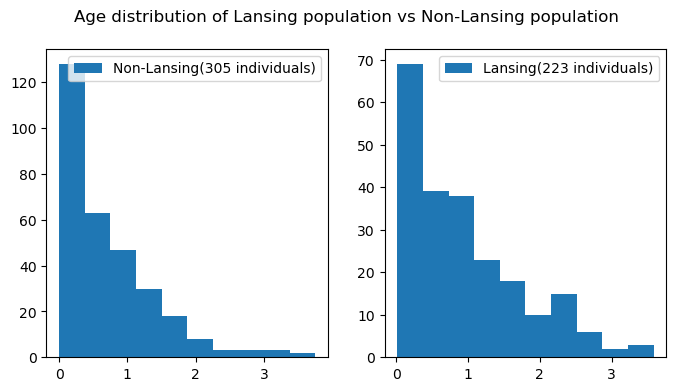

In [755]:
temporal = []
for i in pop17:
    temporal.append(i.age)
plt.figure(figsize=(8, 4))
plt.suptitle('Age distribution of Lansing population vs Non-Lansing population')
plt.subplot(121)
plt.hist(temporal, label='Non-Lansing(305 individuals)')
plt.legend()


temporal = []
for i in pop19:
    temporal.append(i.age)
print(len(pop19))
plt.subplot(122)
plt.hist(temporal, label='Lansing(223 individuals)')
plt.legend()

plt.savefig('ge distribution of Lansing population vs Non-Lansing population.jpg')

(array([128.,  63.,  47.,  30.,  18.,   8.,   3.,   3.,   3.,   2.]),
 array([1.10665062e-03, 3.76398771e-01, 7.51690891e-01, 1.12698301e+00,
        1.50227513e+00, 1.87756725e+00, 2.25285937e+00, 2.62815149e+00,
        3.00344361e+00, 3.37873573e+00, 3.75402785e+00]),
 <BarContainer object of 10 artists>)

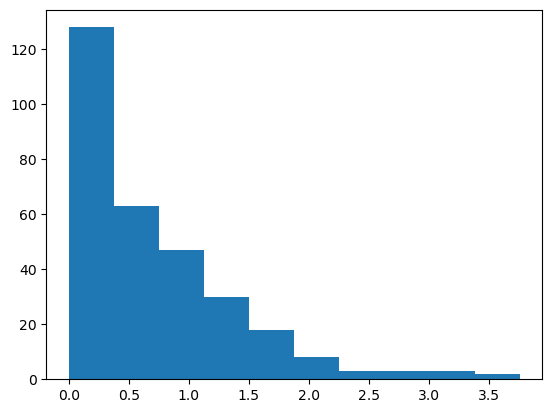

In [746]:
plt.hist(temporal)

In [752]:
len(pop17)

305

(array([69., 39., 38., 23., 18., 10., 15.,  6.,  2.,  3.]),
 array([0.01369749, 0.37074044, 0.72778338, 1.08482633, 1.44186928,
        1.79891222, 2.15595517, 2.51299812, 2.87004107, 3.22708401,
        3.58412696]),
 <BarContainer object of 10 artists>)

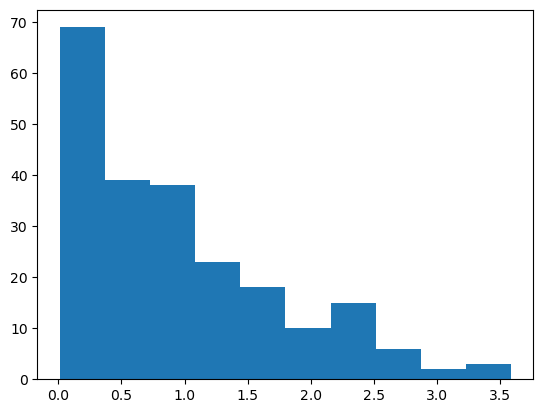

In [749]:
plt.hist(temporal)

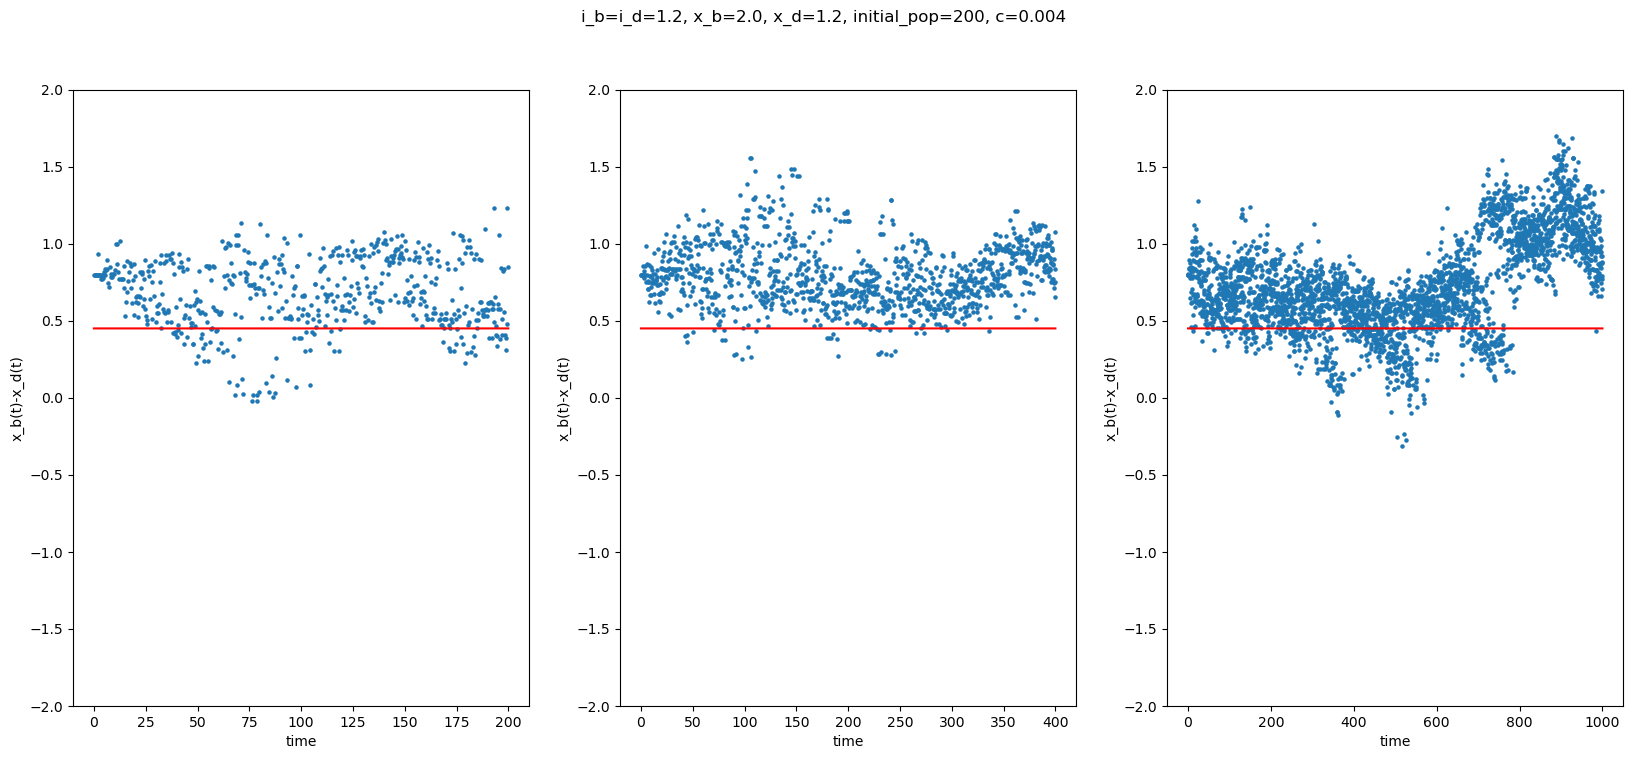

In [470]:
plt.figure(figsize=(20, 8))
plt.suptitle('i_b=i_d=1.2, x_b=2.0, x_d=1.2, initial_pop=200, c=0.004')
plt.ylabel('time')
plt.xlabel('x_b(t) - x_d(t)')
        
plt.subplot(131)
plt.scatter(y =(np.array(xbs15)-np.array(xds15))[::100], x = times15[::100], s=5)
plt.plot(times,[0.45 for i in range(len(times))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.subplot(132)
plt.scatter(y =(np.array(xbs16)-np.array(xds16))[::100], x = times16[::100], s=5)
plt.plot(times1,[0.45 for i in range(len(times1))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.subplot(133)
plt.scatter(y =(np.array(xbs17)-np.array(xds17))[::100], x = times17[::100], s=5)
plt.plot(times2,[0.45 for i in range(len(times2))], color='red')
plt.ylim(-2, 2)
plt.ylabel('x_b(t)-x_d(t)')
plt.xlabel('time')

plt.savefig('xb_high_with_line_high_i_b_keep_200.jpg')

In [1]:
np.corrcoef(xds17, xbs17)

NameError: name 'np' is not defined

In [7]:
#change of values of the lim xb-xd given the parameters ib and id:
def convergence(i_b, i_d):
    return np.log(1 + (i_b + i_d)/i_d) / (i_b + i_d)

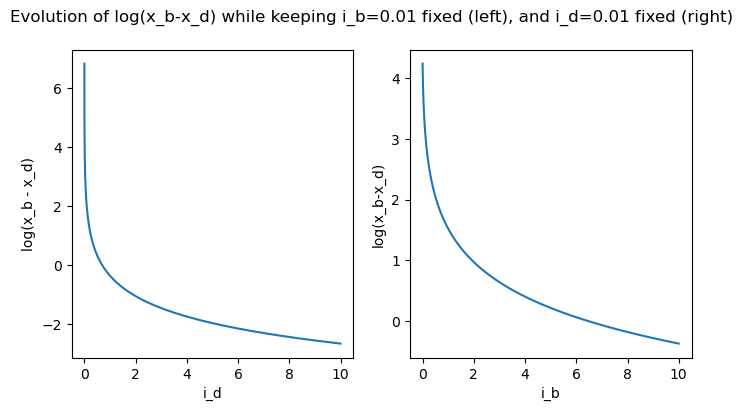

In [17]:
plt.figure(figsize=(8, 4))
plt.suptitle('Evolution of log(x_b-x_d) while keeping i_b=0.01 fixed (left), and i_d=0.01 fixed (right)')
i_b = 0.01
i_d = np.linspace(0.000001, 10, 1000000)
plt.subplot(121)
plt.plot(i_d, [np.log(convergence(i_b, i)) for i in i_d])
plt.xlabel('i_d')
plt.ylabel('log(x_b - x_d)')

i_d = 0.01
i_b = np.linspace(0.000001, 10, 1000000)
plt.subplot(122)
plt.plot(i_b, [np.log(convergence(i, i_d)) for i in i_b])
plt.xlabel('i_b')
plt.ylabel('log(x_b-x_d)')

plt.savefig('Evolution of x_b-x_d.jpg')


# Model 4: Competition, Mutations and Lansing effect

In [535]:
def simulation_lansing(initial_population, max_time, xb_0, xd_0):
    Bacterium.count = 0
    xbs = [xb_0]  # Track x_b values
    xds = [xd_0]  # Track x_d values
    times = [0]   # Track times of events
    time = 0
    pop = []
    diff_mean = []
    diff_iter = 0
    for _ in range(initial_population):
        pop.append(Bacterium(xb_0, xd_0, lansing=True))

    while time < max_time and pop:
        N = len(pop)
        prob_temp = []
        for i in range(N): #creating probabilities of each of the bacterium to have an event
            temp = Bacterium.a_d * N
            if pop[i].age >= pop[i].x_d:
                temp += Bacterium.i_d
            if pop[i].age <= pop[i].x_b:
                temp += Bacterium.i_b
            prob_temp.append(temp)
        # print(np.sum(prob_temp))
        #time = exponential of the sum of all the rates, this comes from the memoryless property of the exponential
        event_time = np.random.exponential(1/np.sum(prob_temp))
        prob_temp = np.array(prob_temp)/np.sum(prob_temp)

        s = np.random.choice(range(N), p=prob_temp)
        # print(s)

        #choosing the event given the individual
        prob_event = [0, Bacterium.a_d * N]
        if pop[s].age >= pop[s].x_d:
            prob_event[1] += Bacterium.i_d
        if pop[s].age <= pop[s].x_b:
            prob_event[0] += Bacterium.i_b
        #print(prob_event)
        prob_event = np.array(prob_event)/np.sum(prob_event)
        event_type = np.random.choice(['birth', 'death'], p=prob_event)
        # print(event_type)

        if event_type == 'birth':
            for bacterium in pop: #add time to bacteria age
                bacterium.age += event_time
            new_bacterium = pop[s].reproduce_lansing(std_dev=0.05, prob=0.1)
            if new_bacterium:
                pop.append(new_bacterium)
                times.append(time)
                xbs.append(new_bacterium.x_b)
                xds.append(new_bacterium.x_d)
                if diff_iter % 1000 == 0:
                    diff_mean.append(np.mean(np.array(xbs)-np.array(xds)))
                    #print(diff_mean)
                # print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {Bacterium.count - 1}, Population: {len(pop)}")
                diff_iter += 1
                #print(diff_iter)
        
        else:
            for bacterium in pop: #add time to bacteria age
                bacterium.age += event_time
            # print(f"Time: {time:.2f}, Event: {event_type}, Bacterium ID: {pop[s].id}, Population: {len(pop)-1}, Age: {pop[s].age}")
            pop.remove(pop[s])

        time += event_time

    return pop, xbs, xds, times, diff_mean

In [771]:
Bacterium.a_d = 0.004
Bacterium.i_b = 1
Bacterium.i_d = 1
pop, xbs, xds, times, diff_mean = simulation_lansing(200, 200, 1.2, 1.6)

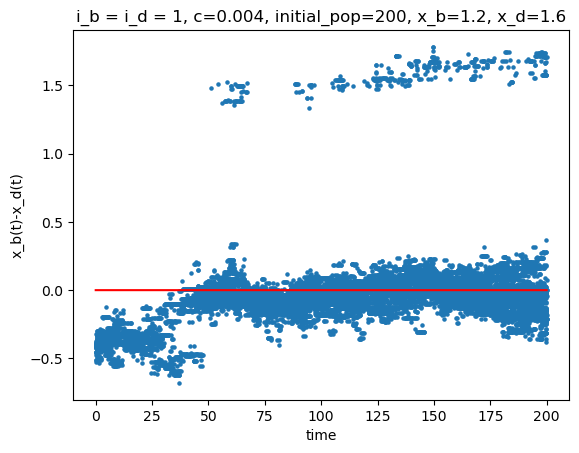

In [772]:
plt.scatter(times, np.array(xbs)-np.array(xds), s=5)
plt.plot(times, [0 for i in times], color='red')
plt.title('i_b = i_d = 1, c=0.004, initial_pop=200, x_b=1.2, x_d=1.6')
plt.xlabel('time')
plt.ylabel('x_b(t)-x_d(t)')
plt.savefig('lansing_default.jpg')

Text(0, 0.5, 'x_b(t)-x_d(t)')

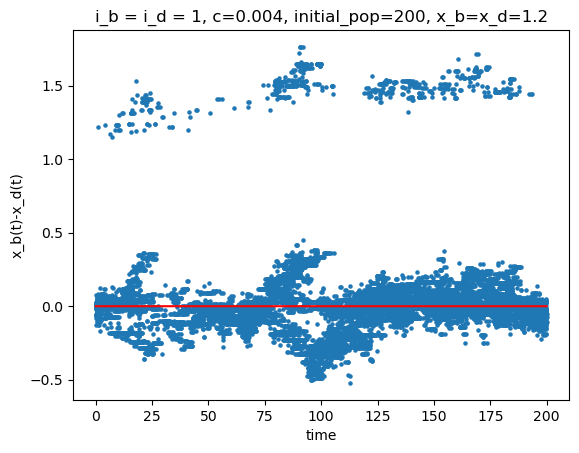

In [775]:
pop1, xbs1, xds1, times1, diff_mean1 = simulation_lansing(200, 200, 1.2, 1.2)

plt.scatter(times1, np.array(xbs1)-np.array(xds1), s=5)
plt.plot(times1, [0 for i in times1], color='red')
plt.title('i_b = i_d = 1, c=0.004, initial_pop=200, x_b=x_d=1.2')
plt.xlabel('time')
plt.ylabel('x_b(t)-x_d(t)')
# plt.savefig('lansing x_b equals x_d.jpg')

In [585]:
Bacterium.a_d = 0.004
Bacterium.i_b = 1.2
Bacterium.i_d = 1.2
pop2, xbs2, xds2, times2, diff_mean2 = simulation_lansing(200, 200, 1.6, 1.2)

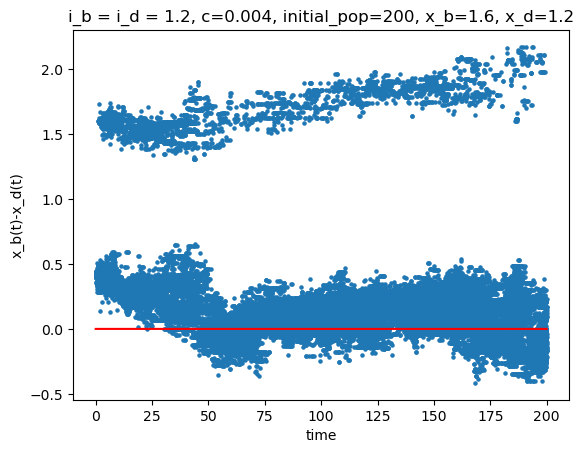

In [777]:
plt.scatter(times2, np.array(xbs2)-np.array(xds2), s=5)
plt.plot(times2, [0 for i in times2], color='red')
plt.title('i_b = i_d = 1.2, c=0.004, initial_pop=200, x_b=1.6, x_d=1.2')
plt.xlabel('time')
plt.ylabel('x_b(t)-x_d(t)')
plt.savefig('lansing x_b geq x_d.jpg')

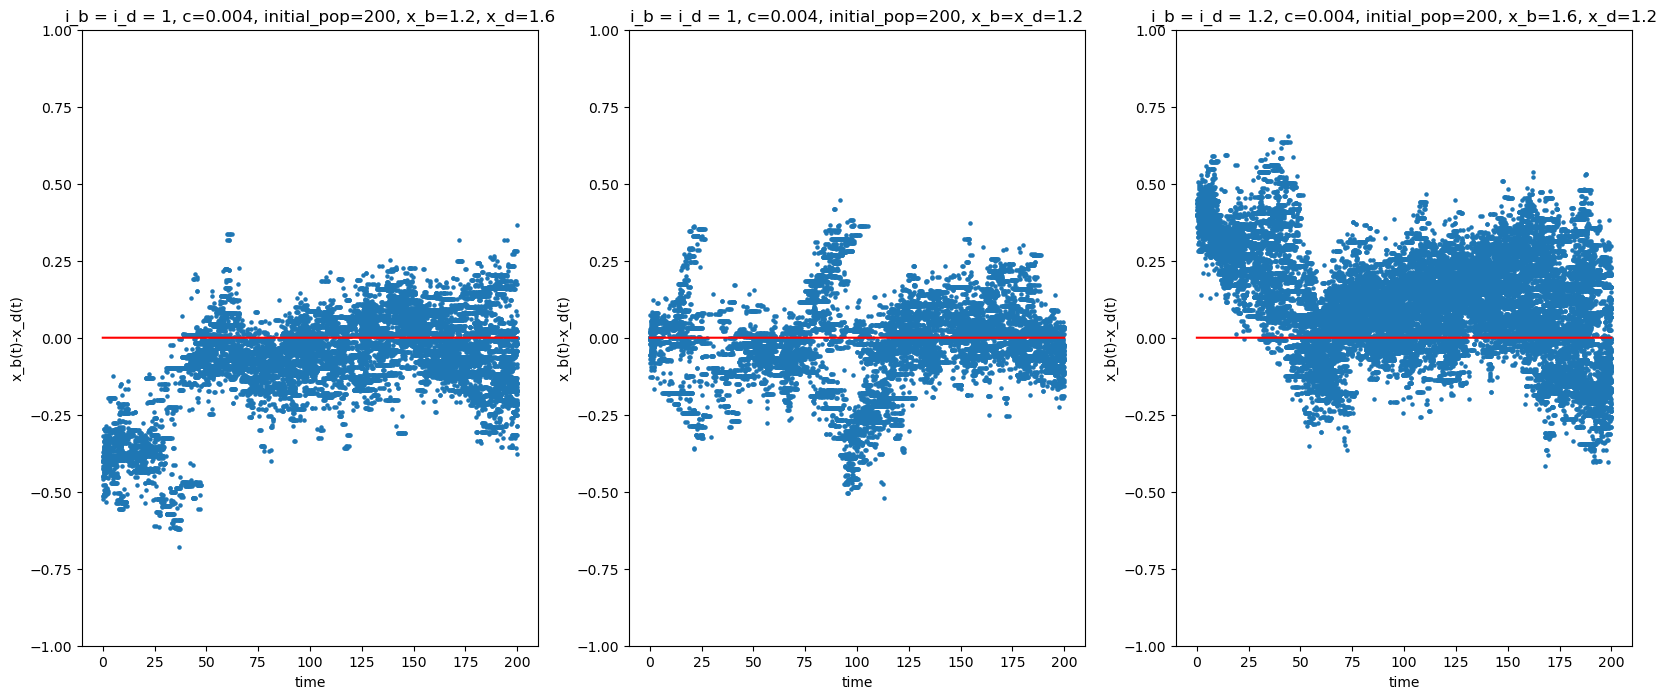

In [780]:
plt.figure(figsize=(20, 8))


plt.subplot(131)
plt.scatter(times, np.array(xbs)-np.array(xds), s=5)
plt.plot(times, [0 for i in times], color='red')
plt.title('i_b = i_d = 1, c=0.004, initial_pop=200, x_b=1.2, x_d=1.6')
plt.ylim(-1, 1)
plt.xlabel('time')
plt.ylabel('x_b(t)-x_d(t)')


plt.subplot(132)
plt.scatter(times1, np.array(xbs1)-np.array(xds1), s=5)
plt.plot(times1, [0 for i in times1], color='red')
plt.title('i_b = i_d = 1, c=0.004, initial_pop=200, x_b=x_d=1.2')
plt.xlabel('time')
plt.ylim(-1, 1)
plt.ylabel('x_b(t)-x_d(t)')

plt.subplot(133)
plt.scatter(times2, np.array(xbs2)-np.array(xds2), s=5)
plt.plot(times2, [0 for i in times2], color='red')
plt.title('i_b = i_d = 1.2, c=0.004, initial_pop=200, x_b=1.6, x_d=1.2')
plt.xlabel('time')
plt.ylabel('x_b(t)-x_d(t)')
plt.ylim(-1, 1)

plt.savefig('lansing convergence 1 cropped.jpg')

In [645]:
pop19, xbs19, xds19, times19, diff_mean19 = simulation_lansing(200, 1000, 1.2, 1.6)

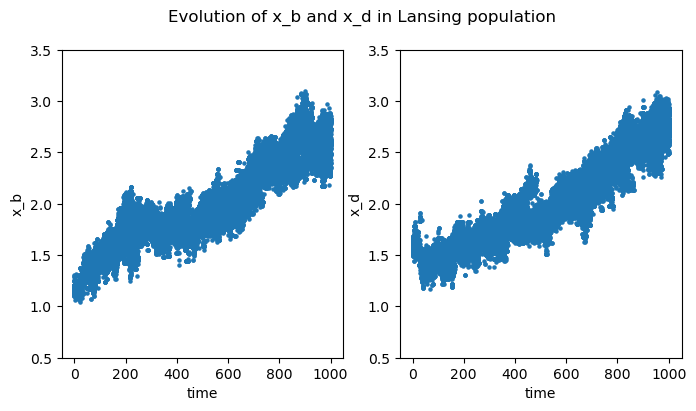

In [652]:
#plots of the evolution of xbs and xds
plt.figure(figsize=(8, 4))
plt.suptitle('Evolution of x_b and x_d in Lansing population')

plt.subplot(121)
plt.scatter(times19, xbs19, s=5)
plt.ylabel('x_b')
plt.xlabel('time')
plt.ylim(0.5, 3.5)

plt.subplot(122)
plt.scatter(times19, xds19, s=5)
plt.ylabel('x_d')
plt.xlabel('time')
plt.ylim(0.5, 3.5)

plt.savefig('Evolution of xbs and xds in a Lansing population.jpg')